Imports

In [1]:
#!pip install pydotplus

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold
from scipy.stats import chi2_contingency # filter method
from sklearn.feature_selection import RFE # wrapper method
from sklearn.linear_model import LassoCV # embedded method
from sklearn.tree import DecisionTreeClassifier # embedded method
from sklearn.model_selection import train_test_split


################################################# MODELS ##################################################
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

################################################# METRICS #################################################
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

#from sklearn.tree import export_graphviz
#import graphviz
#import pydotplus
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
train = pd.read_excel('/kaggle/input/project-ml/historical.xlsx')
test = pd.read_excel('/kaggle/input/project-ml/predict.xlsx')

train.set_index('CustomerID', inplace = True)
test.set_index('CustomerID', inplace = True)

INDEX
- Initial Feature Engineering
- EDA
- Data Cleaning:
    - Numerical:
        - Outliers
        - Transforamtion
        - Scaling
<br></br>
    - Categorical:
        - Encoding
        - Education - Try to reduce number of categories
        - Marital Status - Solve casing issues - Try to reduce number of categories
        - Response Campaign - Try to group in a single var (Number of campaigns responded) or maybe find a cutoff point
        - Kids- Try binary var(have or don't have)
        - Complain - low variability - Try drop
        - Target- DepVar - highly unbalanced set
        - Gender - highly unbalanced set



## Initial Feature Engineering

In [4]:
for df in [train, test]:
# Gender creation
    df['Gender'] = np.where(df['Name'].str.contains('Mr.'), 'M', 'F')

# Antiquity creation
    df[df.Date_Adherence.apply(lambda x: isinstance(x, str))]                                         #16 cases of string 2/29/2022
    df.loc[df.Date_Adherence.apply(lambda x: isinstance(x, str)), 'Date_Adherence'] = '3/01/2022'     # Converted to 3/01/2022 and to datetime object
    df['Date_Adherence'] = pd.to_datetime(df['Date_Adherence'])
    df['Antiquity'] = (datetime.today() - df['Date_Adherence']).dt.days
    df['Antiquity'] = df['Antiquity'].astype(int)

# Age creation
    df['Age'] = datetime.now().year - df.Birthyear
    df['Age'] = df['Age'].astype(int)

#Freq creation
    df['Freq'] = df[['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases', 'NumOfferPurchases']].sum(axis=1)

#Amount Total creation
    df['Mnt_Total'] = df[['MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts','MntAdditionalRequests']].sum(axis=1)

#Drop irrelevant cols
    df.drop(['Name', 'Birthyear', 'Date_Adherence'], axis=1, inplace=True)
    
# Drop duplicates
    df.drop_duplicates(inplace=True)

## EDA

In [5]:
numeric = train[[
    'Income', 'Recency', 'MntMeat&Fish', 'MntEntries', 'MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts', 'MntAdditionalRequests',
    'NumOfferPurchases', 'NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases', 'NumAppVisitsMonth', 'Antiquity', 'Age', 'Freq', 'Mnt_Total'
    ]].copy()

categorical = train[[
    'Education', 'Marital_Status', 'Kid_Younger6', 'Children_6to18', 'Response_Cmp2', 'Response_Cmp3', 'Response_Cmp4', 
    'Response_Cmp5', 'Response_Cmp1', 'Complain', 'DepVar', 'Gender'
    ]].copy()

## Categorical

In [6]:
categorical.astype('object').describe()

,Education,Marital_Status,Kid_Younger6,Children_6to18,Response_Cmp2,Response_Cmp3,Response_Cmp4,Response_Cmp5,Response_Cmp1,Complain,DepVar,Gender
count,2468,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500,2500
unique,5,10,3,3,2,2,2,2,2,2,2,2
top,Graduation,Married,0,0,0,0,0,0,0,0,0,M
freq,1251,1009,1463,1306,2297,2330,2303,2341,2470,2468,2187,1990


In [7]:
train.Education.value_counts()

Graduation    1251
PhD            522
Master         404
HighSchool     225
Basic           66
Name: Education, dtype: int64

In [8]:
train.Marital_Status.value_counts()

Married     1009
Together     592
Single       533
Divorced     212
Widow         82
married       37
single        15
together       9
divorced       6
widow          5
Name: Marital_Status, dtype: int64

## Numeric

In [9]:
numeric.describe()

,Income,Recency,MntMeat&Fish,MntEntries,MntVegan&Vegetarian,MntDrinks,MntDesserts,MntAdditionalRequests,NumOfferPurchases,NumAppPurchases,NumTakeAwayPurchases,NumStorePurchases,NumAppVisitsMonth,Antiquity,Age,Freq,Mnt_Total
count,2500.00000,2452.000000,2500.000000,2500.0000,2500.00000,2479.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.0000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000
mean,77557.22760,48.983279,3071.254400,526.5824,2748.27880,545.916499,524.16320,42.555600,2.454400,5.996800,3.8524,5.828400,5.29280,694.519200,46.379200,18.132000,7454.165200
std,35505.41711,28.636798,3376.433081,761.3516,3875.42553,793.028804,763.86874,49.576031,2.300356,2.757214,3.4258,3.339134,2.71286,203.504919,11.897631,7.972854,7581.458263
min,2678.00000,0.000000,0.000000,0.0000,5.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,350.000000,18.000000,0.000000,18.000000
25%,50998.00000,25.000000,240.000000,40.0000,225.00000,40.000000,40.00000,8.000000,1.000000,4.000000,1.0000,3.000000,3.00000,519.000000,38.000000,11.000000,766.750000
50%,76684.50000,48.000000,1795.000000,180.0000,1110.00000,180.000000,180.00000,24.000000,2.000000,6.000000,3.0000,5.000000,6.00000,686.000000,45.000000,18.000000,4753.500000
75%,101712.00000,73.000000,5050.000000,680.0000,3693.75000,700.000000,680.00000,57.000000,3.000000,8.000000,5.0000,8.000000,7.00000,870.000000,56.000000,24.000000,12585.000000
max,237117.00000,99.000000,14980.000000,3980.0000,24886.00000,3960.000000,3980.00000,249.000000,16.000000,13.000000,24.0000,13.000000,20.00000,1048.000000,75.000000,42.000000,32657.000000


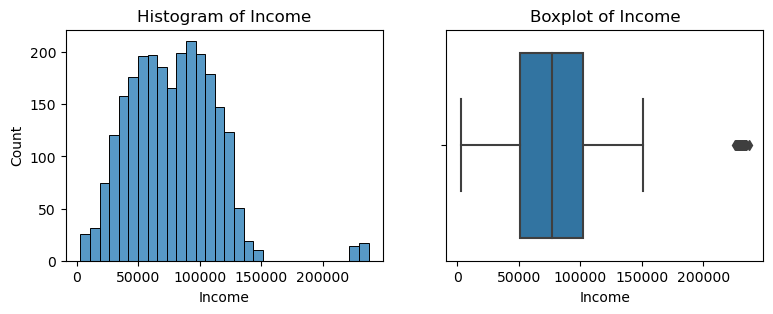

Skew: 0.8279467543830179, Kurtosis : 2.550323618111481


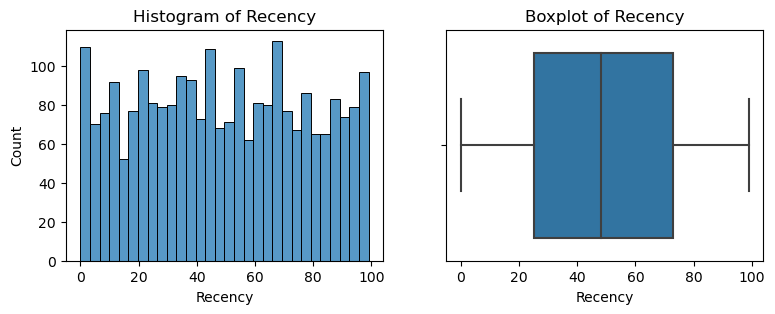

Skew: 0.028003334183665678, Kurtosis : -1.150535984763835


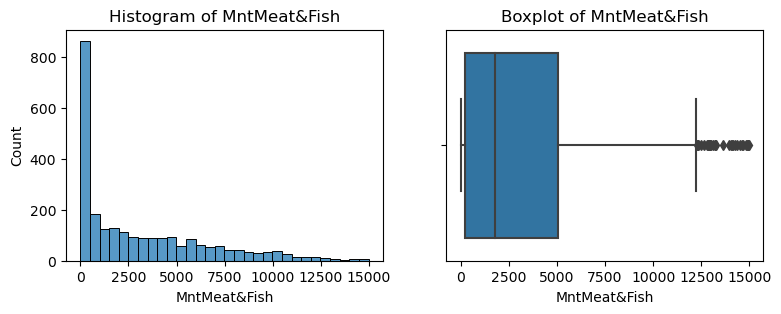

Skew: 1.135132472979566, Kurtosis : 0.4774072234927962


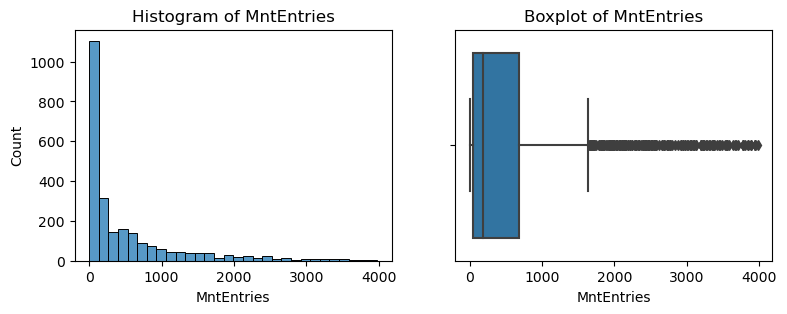

Skew: 2.091728377666883, Kurtosis : 4.292902198701057


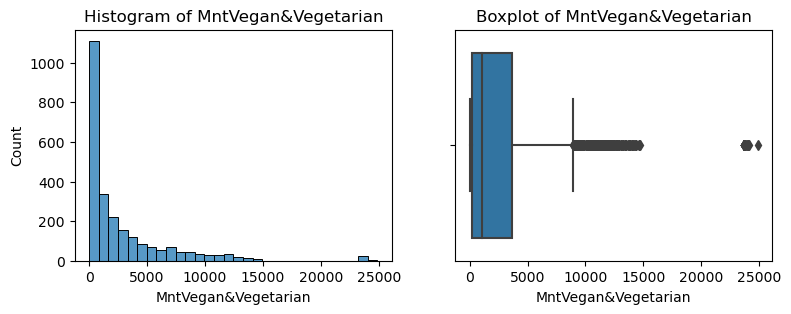

Skew: 2.4795529647990464, Kurtosis : 8.099056921985124


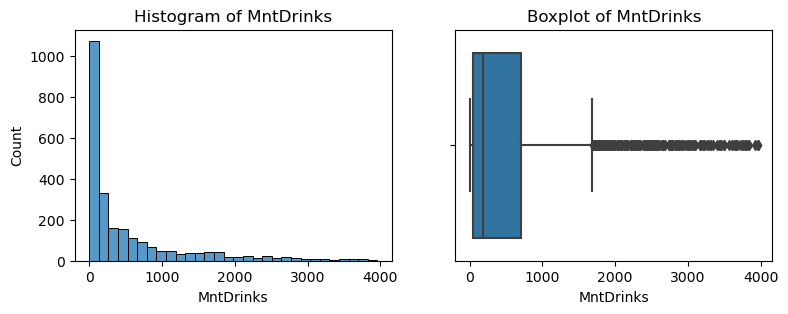

Skew: 2.01621025032237, Kurtosis : 3.7427002389973048


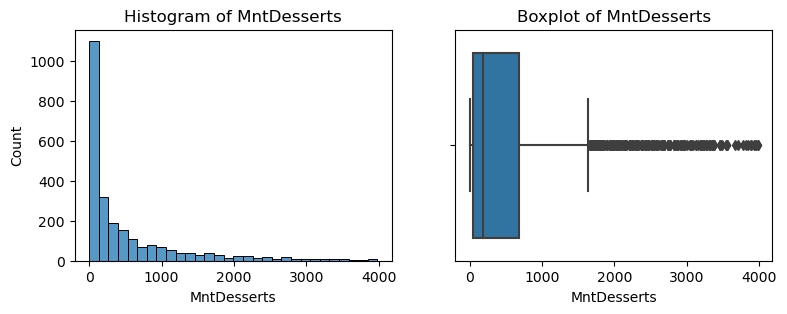

Skew: 2.071036987626397, Kurtosis : 4.0847740838963835


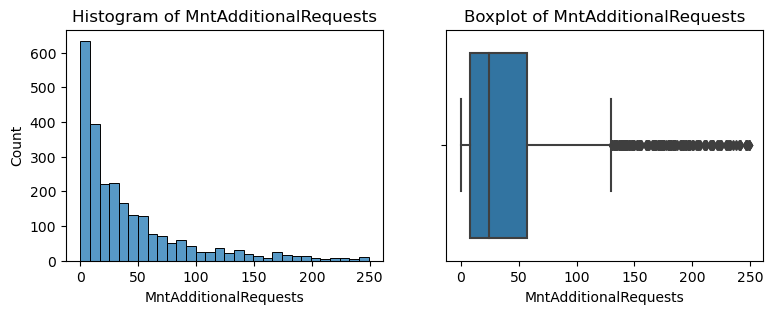

Skew: 1.8497950464594828, Kurtosis : 3.246925765909702


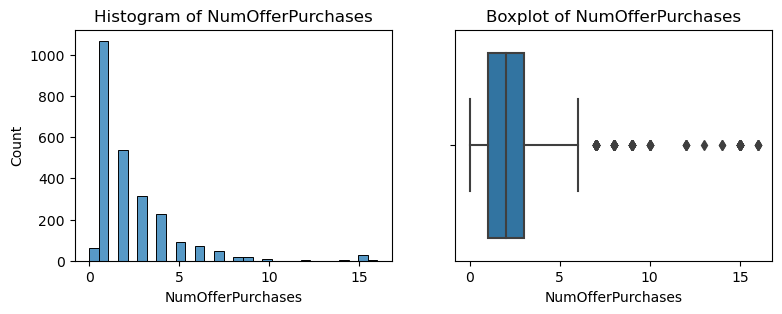

Skew: 2.8754868798433155, Kurtosis : 11.29364854186155


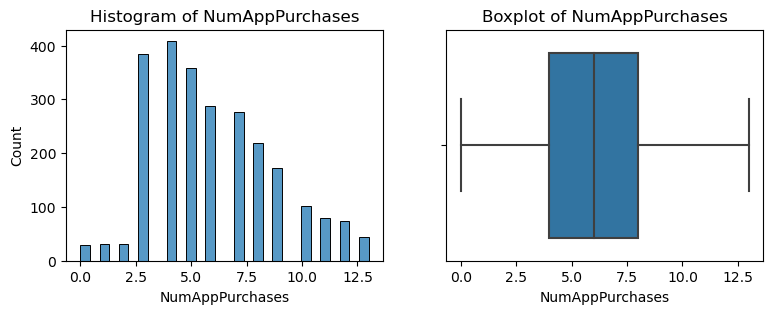

Skew: 0.5352427343804749, Kurtosis : -0.2154201568874261


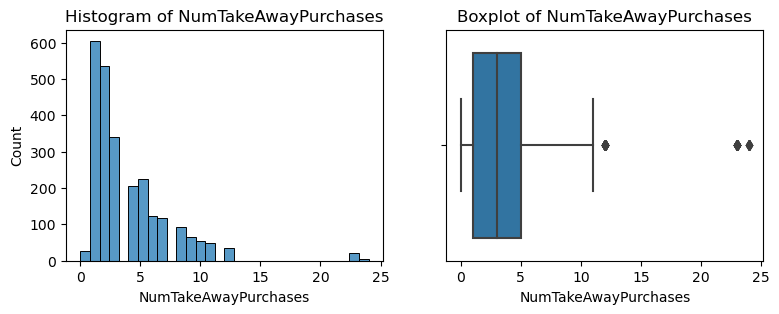

Skew: 2.3900164618425097, Kurtosis : 9.14690092475826


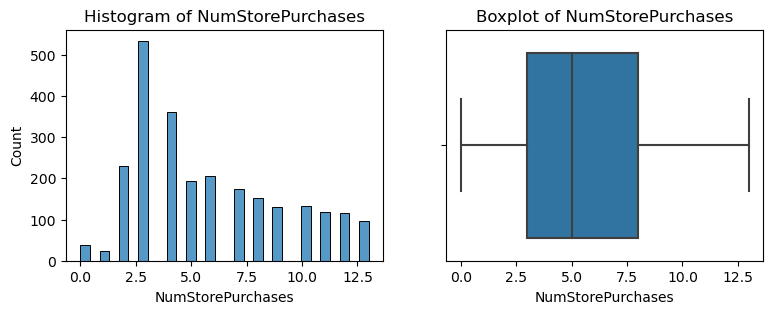

Skew: 0.6119897083696106, Kurtosis : -0.7240328472444681


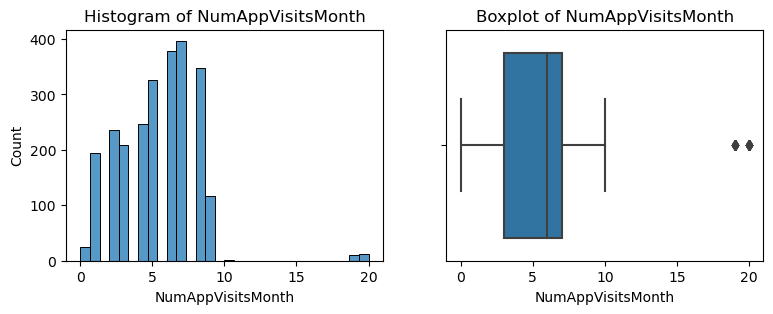

Skew: 0.9706319237195967, Kurtosis : 4.989026719884712


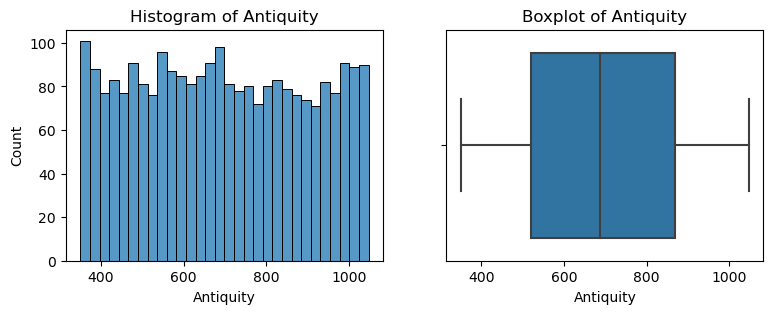

Skew: 0.0427689679463382, Kurtosis : -1.1915784398953502


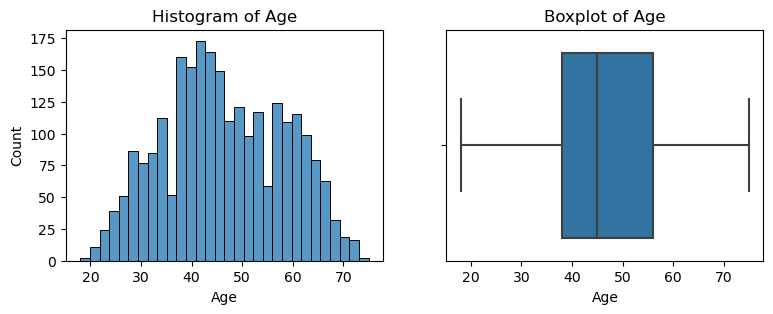

Skew: 0.06304240758491092, Kurtosis : -0.8168653337922467


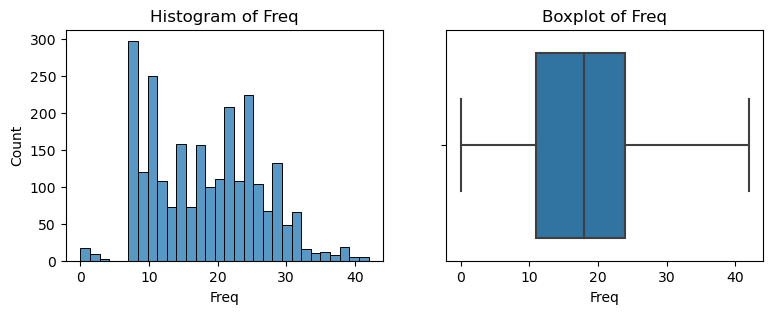

Skew: 0.22520269262336717, Kurtosis : -0.7142312507954243


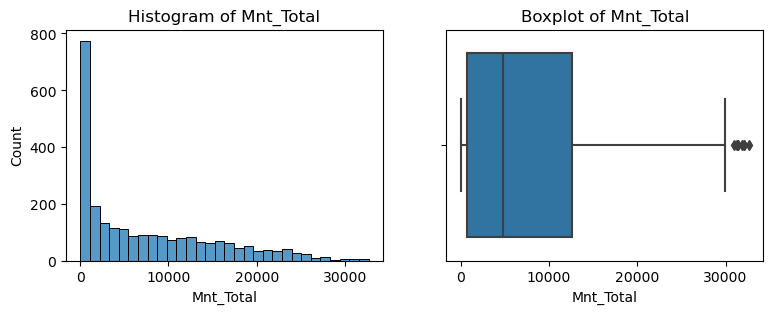

Skew: 0.9429060100563523, Kurtosis : -0.1328564214356307


In [10]:
for var in numeric:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
    sns.histplot(ax=ax1, x=numeric[var], bins=30)
    sns.boxplot(ax=ax2, x=numeric[var])
    ax1.set_title(f"Histogram of {var}")
    ax2.set_title(f"Boxplot of {var}")
    plt.show()
    print(f'Skew: {numeric[var].skew()}, Kurtosis : {numeric[var].kurt()}')

## Outliers

### Z Score Method

In [11]:
total=0
for i in numeric:
   # Calculate Z-scores
    z_scores = np.abs(stats.zscore(numeric[i]))

    # Define a threshold for outlier detection
    threshold = 3  

    # Identify outliers
    outliers = np.where(z_scores > threshold)[0]
    total += len(outliers)

    if len(outliers) > 0:
        print(f'{i} has {len(outliers)} outliers')
print(f'Total number of outliers - {total}')

Income has 31 outliers
MntMeat&Fish has 17 outliers
MntEntries has 64 outliers
MntVegan&Vegetarian has 29 outliers
MntDesserts has 70 outliers
MntAdditionalRequests has 60 outliers
NumOfferPurchases has 45 outliers
NumTakeAwayPurchases has 26 outliers
NumAppVisitsMonth has 22 outliers
Mnt_Total has 8 outliers
Total number of outliers - 372


### IQR Method

In [12]:
total = 0
for i in numeric:
    Q1 = np.percentile(numeric[i], 25)
    Q3 = np.percentile(numeric[i], 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 + IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = numeric[(numeric[i] < lower_bound) | (numeric[i] > upper_bound)]
    total += len(outliers)
    if len(outliers) > 0:
        print(f'{i} has {len(outliers)} outliers')
print(f'Total number of outliers - {total}')

Income has 1906 outliers
MntMeat&Fish has 1908 outliers
MntEntries has 2102 outliers
MntVegan&Vegetarian has 2081 outliers
MntDesserts has 2113 outliers
MntAdditionalRequests has 2046 outliers
NumOfferPurchases has 1255 outliers
NumAppPurchases has 1533 outliers
NumTakeAwayPurchases has 1567 outliers
NumStorePurchases has 1583 outliers
NumAppVisitsMonth has 1259 outliers
Antiquity has 1872 outliers
Age has 1783 outliers
Freq has 1677 outliers
Mnt_Total has 1883 outliers
Total number of outliers - 26568


## Other Vars

In [13]:
train[['Revenue','CostContact','Complain']].describe

<bound method NDFrame.describe of             Revenue  CostContact  Complain
CustomerID                                
30651            16            3         0
6222             16            3         0
3909             16            3         0
20121            16            3         0
19896            16            3         0
...             ...          ...       ...
13344            16            3         0
28152            16            3         0
31938            16            3         0
20016            16            3         0
15492            16            3         0

[2500 rows x 3 columns]>

In [14]:
train.Complain.value_counts()

0    2468
1      32
Name: Complain, dtype: int64

### Conclusions
- 18 duplicated rows - drop them 
- Nan's (Education - 33, Recency - 48, MntDrinks - 21)

- Numeric
    - Incongruence in Freq (some has 0 but spent money) - set to 1 low values and remove two cases with high amount spent
    - Cost Contact and Revenue are constant - drop them
    - Outliers - try with and without
    - Distributions - apply transformation to help normalize 
    - Scaling - standardize 


- Categorical - 12 vars
    - Education - Try to reduce number of categories
    - Marital Status - Solve casing issues - Try to reduce number of categories
    - Response Campaign - Try to group in a single var (Number of campaigns responded) or maybe find a cutoff point
    - Kids- Try binary var(have or don't have)
    - Complain - low variability - Try drop
    - Target- DepVar - highly unbalanced set
    - Gender - highly unbalanced set



## Data Cleaning

### Missing Values

- Education (categorical): Mode
- Recency: Which variables correlate more with Recency? (Median maybe because there is no high correlations)
- MntDrinks: High correlation with MntEntries, MntVegan&Vegetarian, MntDesserts and Mnt_Total(0.7) — we will use KNN imputer to fill the NA's.

In [15]:
# Education
train.Education.fillna(train['Education'].mode()[0], inplace = True)
test.Education.fillna(train['Education'].mode()[0], inplace = True)

#Recency
train.Recency.fillna(train.Recency.median(),inplace = True)
test.Recency.fillna(train.Recency.median(),inplace = True)

#MntDrinks

numeric_knn = numeric[['MntDrinks','MntVegan&Vegetarian', 'MntDesserts', 'Mnt_Total']]
imputer = KNNImputer(n_neighbors = 1)
array_impute = imputer.fit_transform(numeric_knn)
numeric_knn = pd.DataFrame(array_impute, columns = numeric_knn.columns)
train['MntDrinks'] = numeric_knn['MntDrinks'].values
test['MntDrinks'] = numeric_knn['MntDrinks'].values 

### Numeric

In [16]:
# Freq Incongruence
train.drop(train[(train['Freq'] == 0) & (train['Mnt_Total'] > 20000)].index, inplace=True)
train.loc[train['Freq'] == 0, 'Freq'] = 1

# Drop Cost Contact & Revenue
train.drop(['CostContact', 'Revenue'], axis=1, inplace=True)
test.drop(['CostContact', 'Revenue'], axis=1, inplace=True)

### Transformation

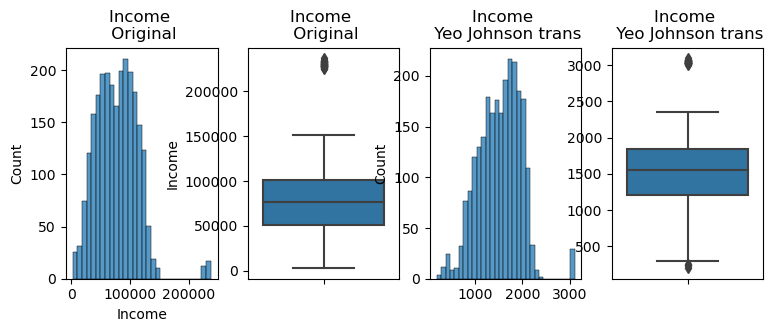

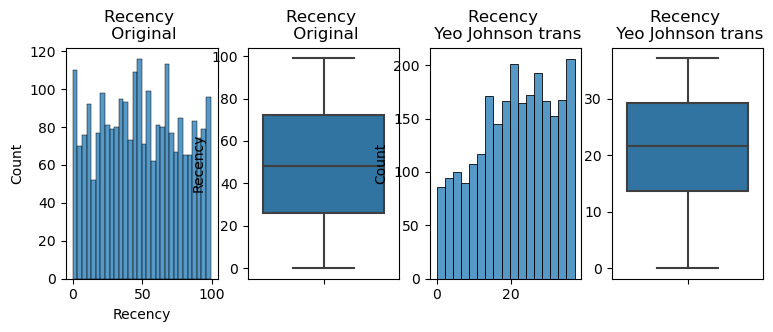

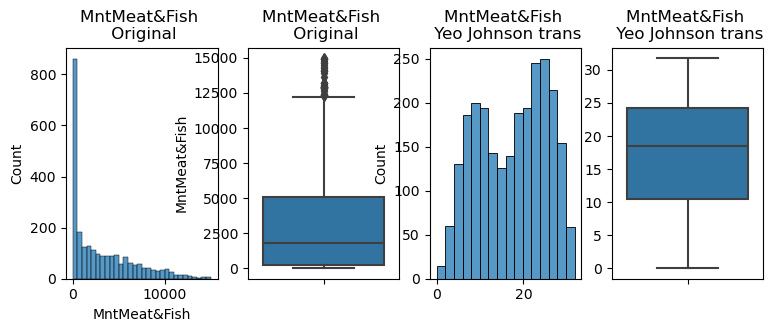

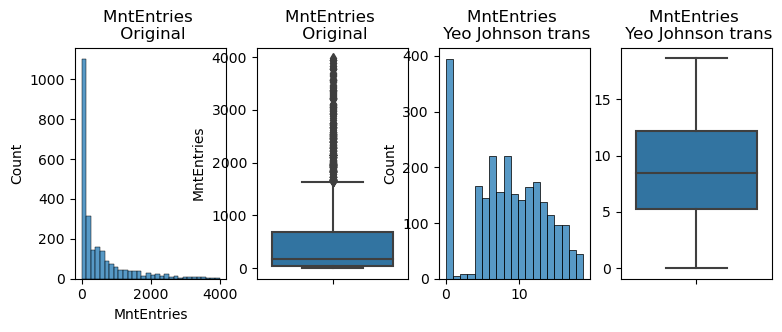

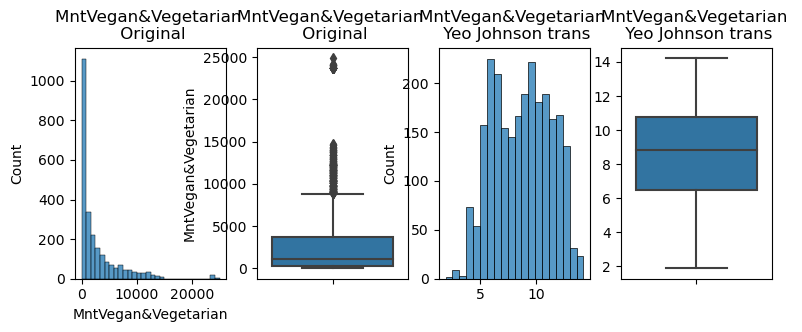

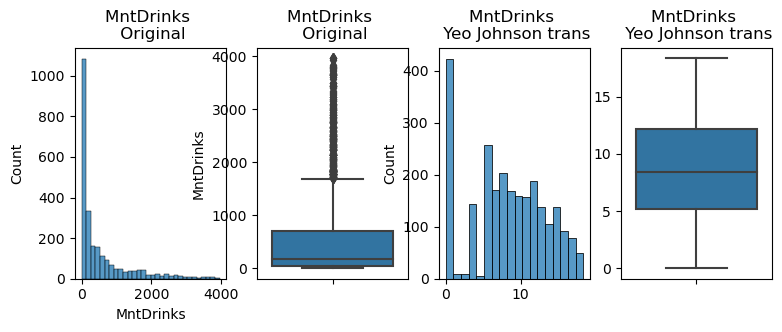

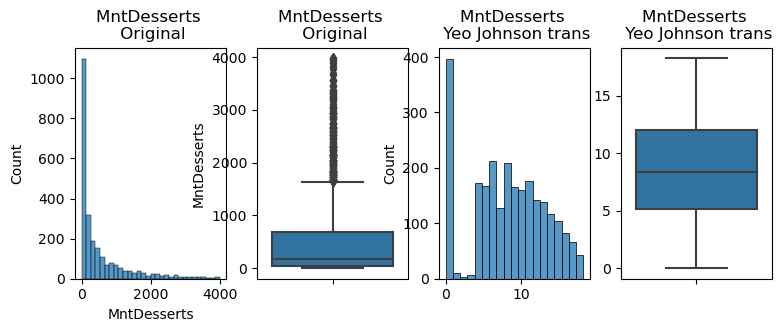

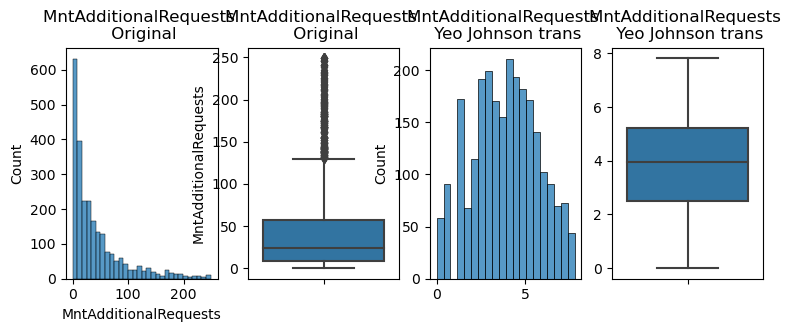

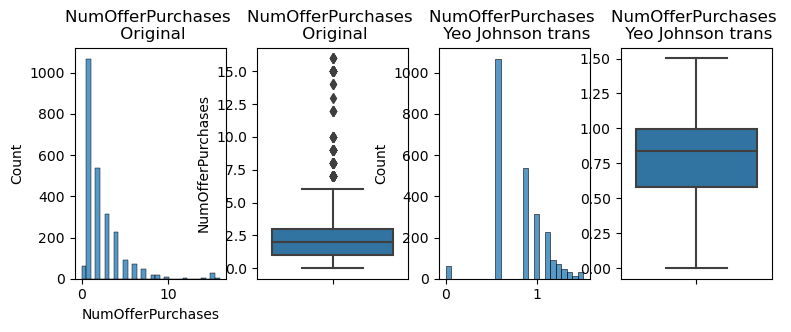

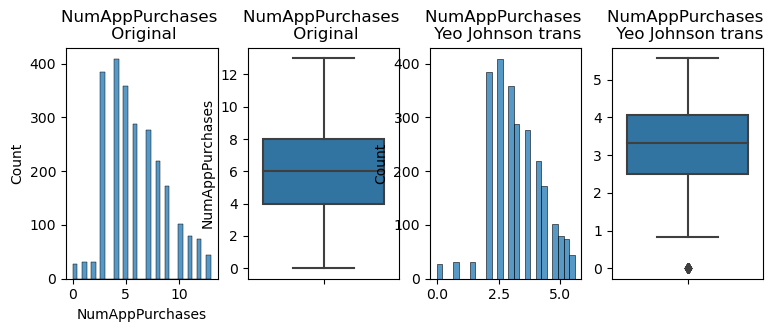

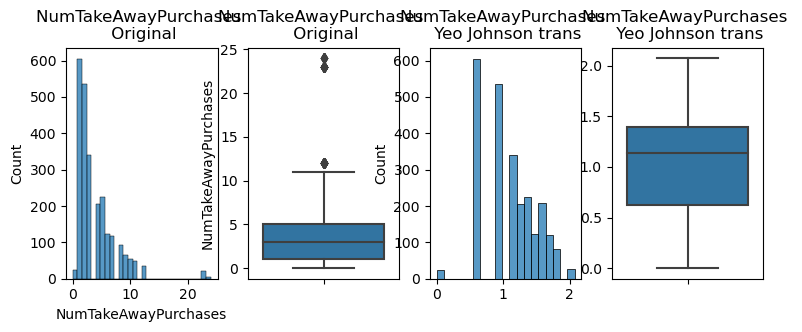

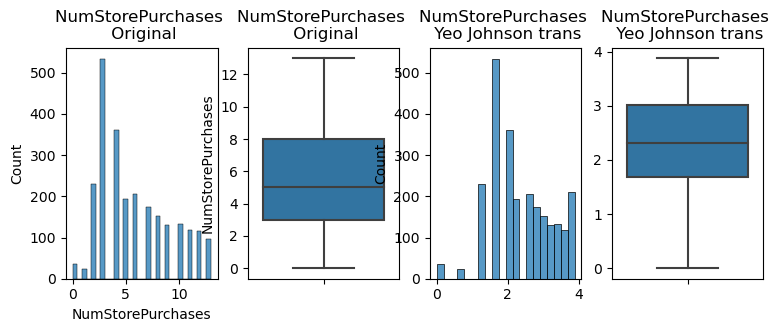

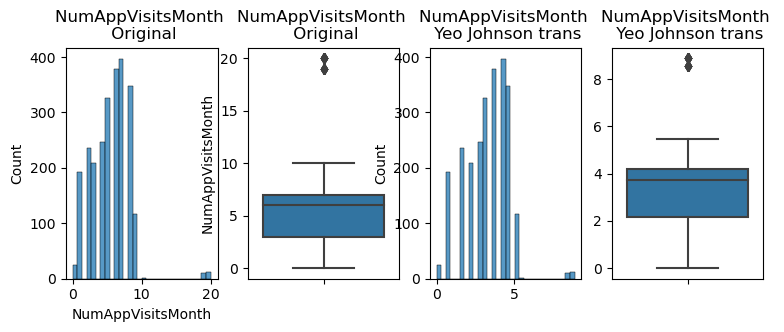

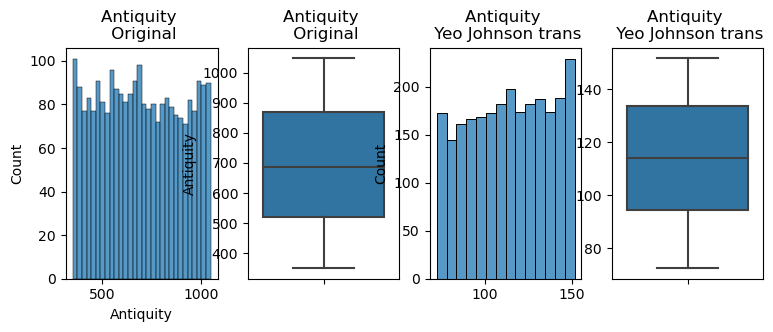

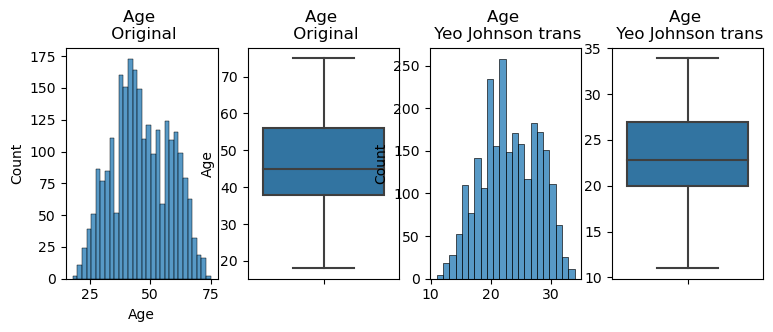

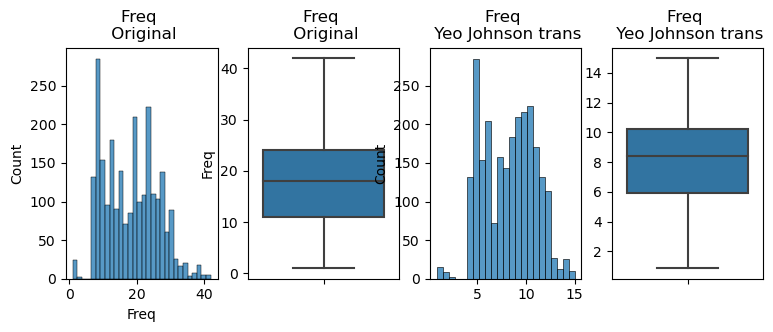

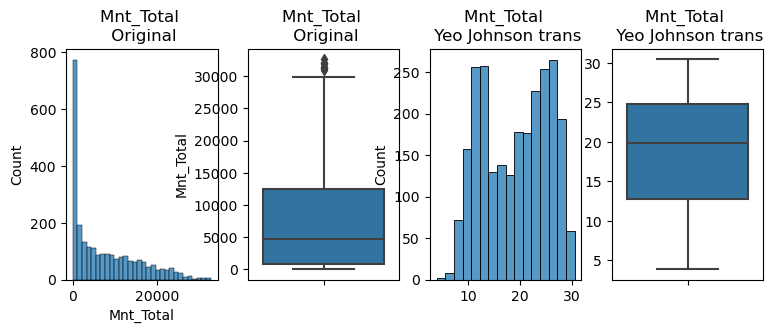

In [17]:
for var in numeric:
    xt, lmbda = stats.yeojohnson(train[var])
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(9, 3))
    sns.histplot(ax=ax1, x=train[var], bins=30)
    sns.boxplot(ax=ax2, y= train[var] )
    sns.histplot(ax=ax3, x=xt)
    sns.boxplot(ax=ax4, y= xt)
    ax1.set_title(f"{var} \n Original")
    ax2.set_title(f"{var} \n Original")
    ax3.set_title(f"{var} \n Yeo Johnson trans")
    ax4.set_title(f"{var} \n Yeo Johnson trans")
    plt.show()


In [18]:
# Apply trans to all numerical vars but Age and Income
trans = train[['Recency','MntMeat&Fish', 'MntEntries','MntVegan&Vegetarian', 'MntDrinks', 'MntDesserts',
        'MntAdditionalRequests', 'NumOfferPurchases', 'NumAppPurchases','NumTakeAwayPurchases', 'NumStorePurchases', 
        'NumAppVisitsMonth','Antiquity','Freq', 'Mnt_Total']].copy()

for var in trans.columns:
    train[var], lmbda = stats.yeojohnson(train[var])
    test[var], lmbda = stats.yeojohnson(test[var])

### Outliers

In [19]:
total=0
for i in numeric.columns:
   # Calculate Z-scores
    z_scores = np.abs(stats.zscore(train[i]))

    # Define a threshold for outlier detection
    threshold = 3  

    # Identify outliers
    outliers = np.where(z_scores > threshold)[0]
    total += len(outliers)

    if len(outliers) > 0:
        print(f'{i} has {len(outliers)} outliers')
print(f'Total number of outliers = {total}')
    

Income has 29 outliers
NumAppPurchases has 28 outliers
NumAppVisitsMonth has 22 outliers
Total number of outliers = 79


In [20]:
train = train.drop(train[train['Income'] > 200000].index)
train = train.drop(train[train['NumAppPurchases'] < 0.5].index)
train = train.drop(train[train['NumAppVisitsMonth'] > 8].index)

## Sscaling

Three approaches to numerical data standardization: MinMax, Standard and Robust Scaling 

MinMaxScaler: rescales the data set so that all feature values are within the range [0, 1] or [-1, 1] if there are negative values

 . preserves the original distribution of the data.

 . less affected by outliers compared to StandardScaler.

StandardScaler transforms each feature in the data set to have a mean of 0 and a standard deviation of 1, resulting in a standard normal distribution

 . allows for fair comparisons between different features

 . useful for algorithms that assume data to be normally distributed, such as linear or logistic regression

RobustScaler scales the features using statistics that are robust to outliers, specifically by subtracting the median and dividing by the interquartile range (IQR)

 . less affected by outliers than MinMax or Standard Scaling

 . preserves the shape of the original distribution while standardizing features to a similar scale

In [21]:
# Creating a copy of the dataframe for each scaler
# numeric_minmax = numeric.copy()
# numeric_standard = numeric.copy()
# numeric_robust = numeric.copy()
# #Three transformations
# scaler_minmax = MinMaxScaler()
# numeric_minmax = pd.DataFrame(scaler_minmax.fit_transform(numeric_minmax), columns=numeric.columns)

# scaler_standard = StandardScaler()
# numeric_standard = pd.DataFrame(scaler_standard.fit_transform(numeric_standard), columns=numeric.columns)

# scaler_robust = RobustScaler()
# numeric_robust = pd.DataFrame(scaler_robust.fit_transform(numeric_robust), columns=numeric.columns)

scaler= StandardScaler()
train[numeric.columns] = scaler.fit_transform(train[numeric.columns])
test[numeric.columns] = scaler.fit_transform(test[numeric.columns])

## Categorical

In [22]:
# Has kids binary
train['Have_kids'] = (train['Kid_Younger6'] + train['Children_6to18']).apply(lambda x: 1 if x > 0 else 0)
test['Have_kids'] = (test['Kid_Younger6'] + test['Children_6to18']).apply(lambda x: 1 if x > 0 else 0)

In [23]:
# Education Binning
train.Education = train.Education.str.title() 
train['Education_bins_3'] = train.Education.replace({
    'Phd': 'High',
    'Master' : 'High',
    'Graduation': 'Medium',
    'Basic' : 'Low',
    'Highschool' : 'Medium'
})

train['Education_bins_2'] = train.Education.replace({
    'Phd': 'High',
    'Master' : 'High',
    'Graduation': 'Low',
    'Basic' : 'Low',
    'Highschool' : 'Low'
})

test.Education = test.Education.str.title() 
test['Education_bins_3'] = test.Education.replace({
    'Phd': 'High',
    'Master' : 'High',
    'Graduation': 'Medium',
    'Basic' : 'Low',
    'Highschool' : 'Medium'
})

test['Education_bins_2'] = test.Education.replace({
    'Phd': 'High',
    'Master' : 'High',
    'Graduation': 'Low',
    'Basic' : 'Low',
    'Highschool' : 'Low'
})


In [24]:
# Marital_Status binning

train.Marital_Status = train.Marital_Status.str.title()
train['Marital_Status_2'] = train.Marital_Status.replace({
    'Married' : 'Together',
    'Single' : 'Single',
    'Divorced' : 'Single',
    'Widow' : 'Single'
})

train['Marital_Status_4'] = train.Marital_Status.replace('Married','Together')

test.Marital_Status = test.Marital_Status.str.title()
test['Marital_Status_2'] = test.Marital_Status.replace({
    'Married' : 'Together',
    'Single' : 'Single',
    'Divorced' : 'Single',
    'Widow' : 'Single'
})

test['Marital_Status_4'] = test.Marital_Status.replace('Married','Together')

In [25]:
# Campaign Response Join

train['Campaign_ordinal'] = train.Response_Cmp1 + train.Response_Cmp2 + train.Response_Cmp3 + train.Response_Cmp4 + train.Response_Cmp5
test['Campaign_ordinal'] = test.Response_Cmp1 + test.Response_Cmp2 + test.Response_Cmp3 + test.Response_Cmp4 + test.Response_Cmp5

# Feature Selection

In [26]:
X = train.drop('DepVar', axis = 1)
y = train['DepVar'].copy()
skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)

## Categorical Features

### Chi-Square

In [27]:
def apply_chisquare(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)
    
    
def select_best_cat_features(X,y):
    count = 1

    ############################################## APPLY SKF ######################################################
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]


        #################################### SELECT FEATURES WITH CHI-SQUARE #######################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using chi-square
        X_train_cat = X_train[['Education', 'Marital_Status', 'Kid_Younger6', 'Children_6to18',
       'Response_Cmp2', 'Response_Cmp3', 'Response_Cmp4', 'Response_Cmp5',
       'Response_Cmp1', 'Complain', 'Gender', 'Have_kids', 'Education_bins_3', 'Education_bins_2', 'Marital_Status_2', 'Marital_Status_4', 'Campaign_ordinal' ]].copy()
        for var in X_train_cat:
            apply_chisquare(X_train_cat[var],y_train, var)

        count+=1

In [28]:
select_best_cat_features(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
Education is NOT an important predictor. (Discard Education from model)
Marital_Status is IMPORTANT for Prediction
Kid_Younger6 is NOT an important predictor. (Discard Kid_Younger6 from model)
Children_6to18 is IMPORTANT for Prediction
Response_Cmp2 is IMPORTANT for Prediction
Response_Cmp3 is IMPORTANT for Prediction
Response_Cmp4 is IMPORTANT for Prediction
Response_Cmp5 is IMPORTANT for Prediction
Response_Cmp1 is IMPORTANT for Prediction
Complain is NOT an important predictor. (Discard Complain from model)
Gender is NOT an important predictor. (Discard Gender from model)
Have_kids is IMPORTANT for Prediction
Education_bins_3 is IMPORTANT for Prediction
Education_bins_2 is NOT an important predictor. (Discard 

In [29]:
# Drop Gender and Education ??

## Numerical Features

### Variance
Variance to understand if our numerical data and ordinal data is constant or quasi-constant.

In [30]:
def apply_variance(X_train): 
    print(X_train.var())
    

def select_features_variance(X, y):
    count = 1 
    for train_index, val_index in skf.split(X, y): 
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using variance
        apply_variance(X_train)
            
        count+=1

In [31]:
select_features_variance(X, y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
Income                   0.996653
Kid_Younger6             0.301591
Children_6to18           0.299283
Recency                  0.989304
MntMeat&Fish             1.010173
MntEntries               0.996597
MntVegan&Vegetarian      1.007718
MntDrinks                0.990361
MntDesserts              0.993293
MntAdditionalRequests    0.975157
NumOfferPurchases        1.000208
NumAppPurchases          1.004238
NumTakeAwayPurchases     1.013384
NumStorePurchases        0.992433
NumAppVisitsMonth        0.998654
Response_Cmp2            0.076072
Response_Cmp3            0.066549
Response_Cmp4            0.073069
Response_Cmp5            0.060356
Response_Cmp1            0.013634
Complain                 0.011138
Antiquit

- The variables Responses and Complain has around 0
- Kid_Younger6 and Children_6to18 have 0.3 

In [32]:
# Droping space

### Spearman Correlation

- Exclude target, Complain and responses variables (binary)

In [33]:
def cor_heatmap(cor):
    plt.figure(figsize = (15,12))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt = '.1')
    plt.show()
    
    
def apply_correlation(X_train):
    correlation_data = X_train.drop(['Response_Cmp1', 'Response_Cmp2', 'Response_Cmp3', 'Response_Cmp4', 'Response_Cmp5', 'Complain'], axis = 1).copy()
    matrix = correlation_data.corr(method = 'spearman')
    cor_heatmap(matrix)

We will now examine the correlation of the independent features in the training data.

In [34]:
def redundant_features(X,y): 
    count = 1
    
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        # check which features to use using spearman correlation
        apply_correlation(X_train)
        
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


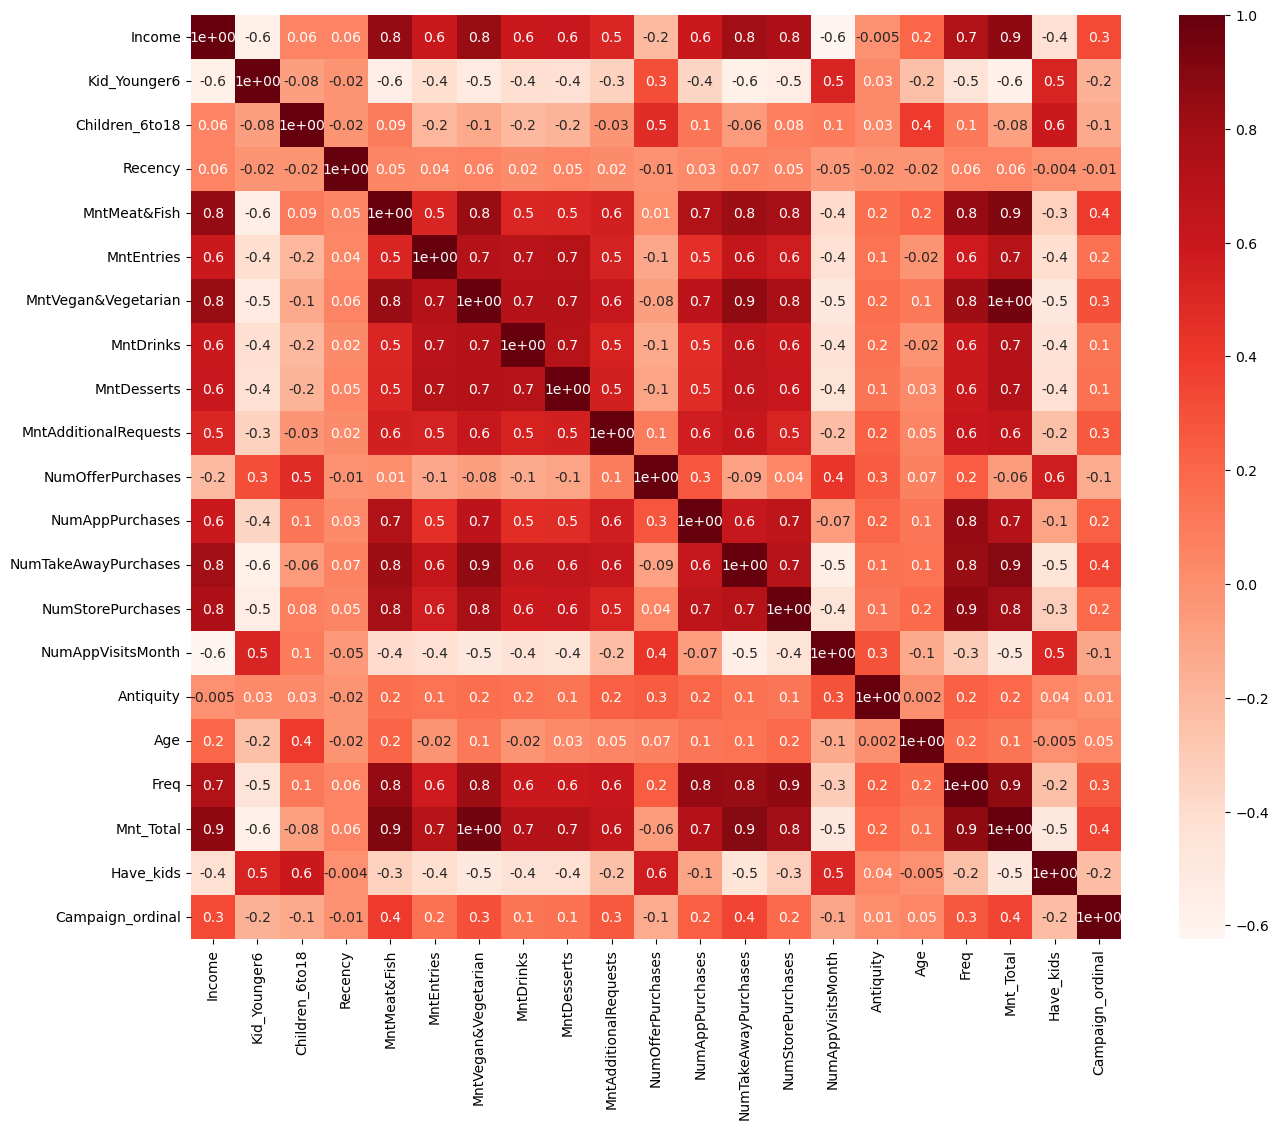

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


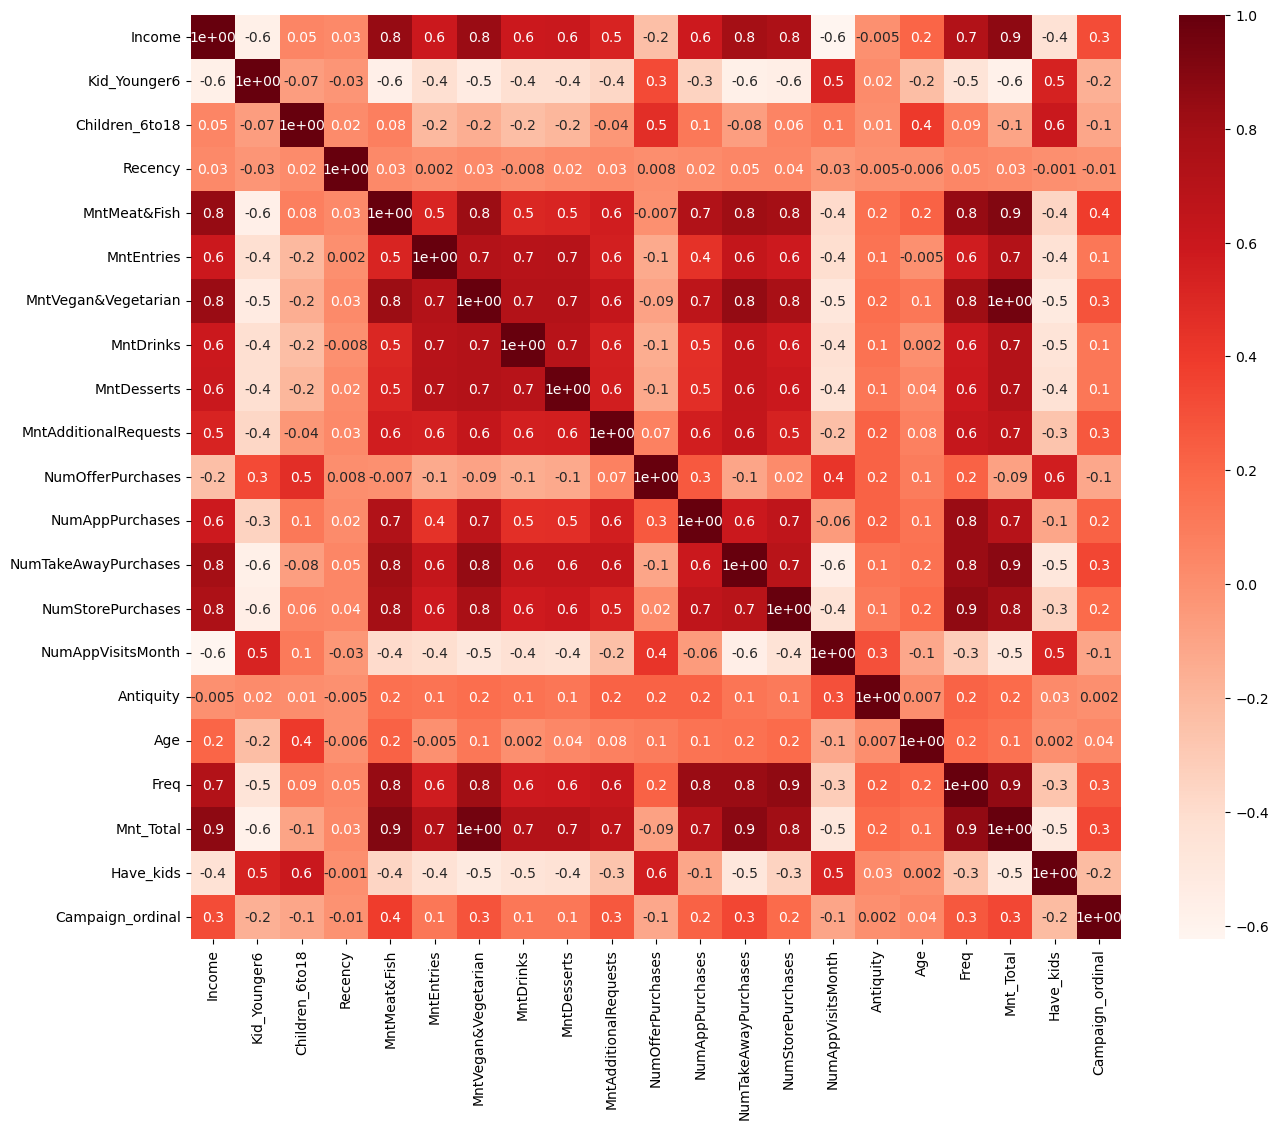

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


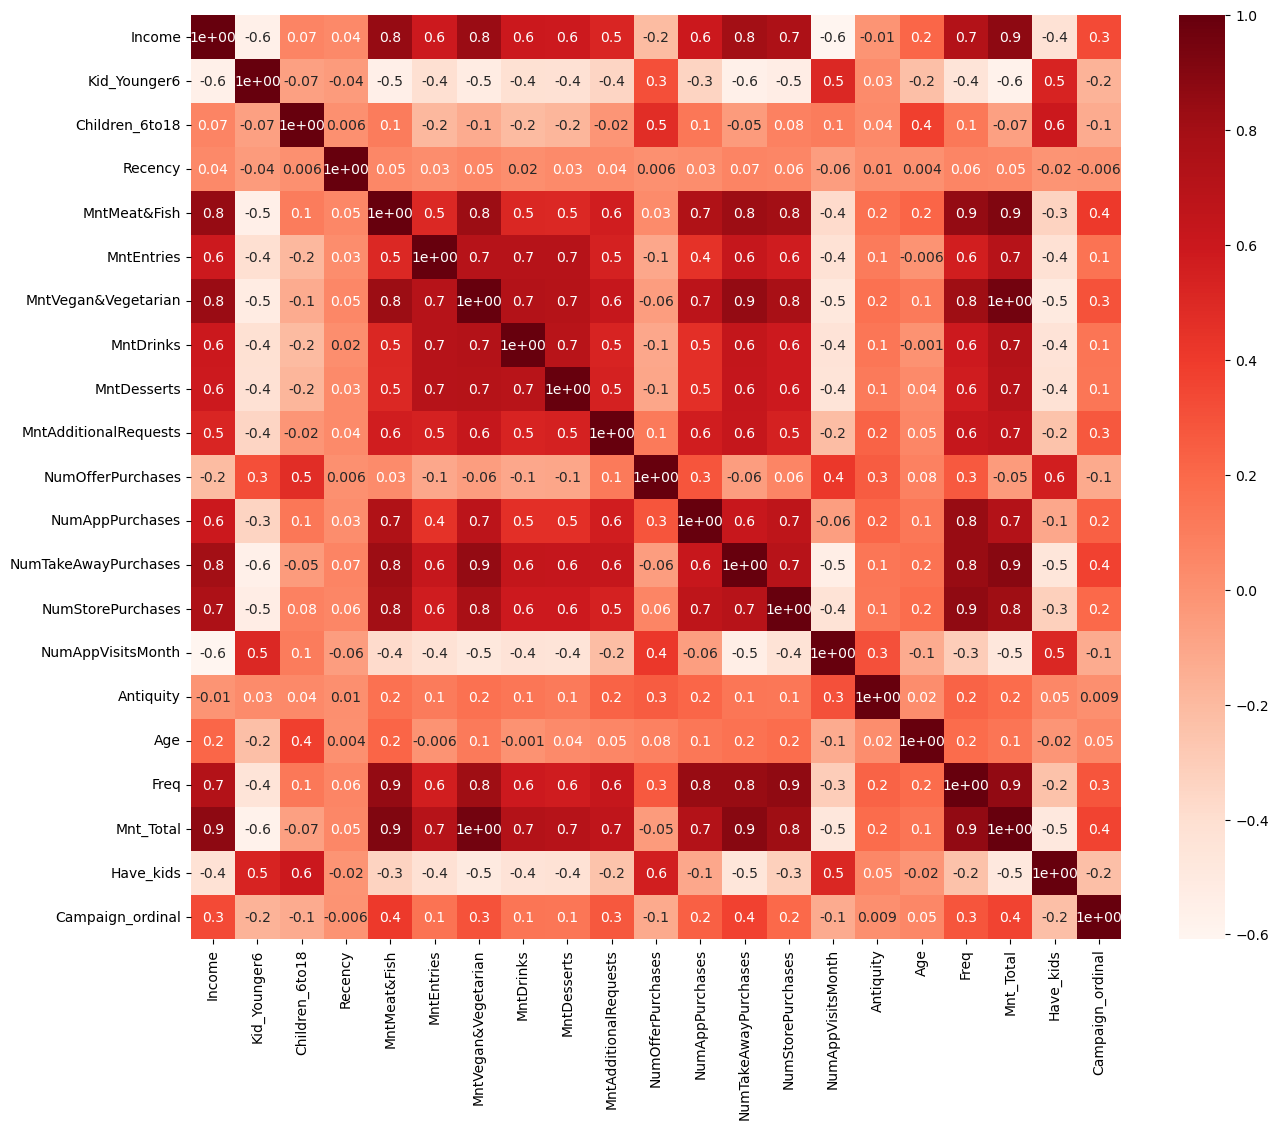

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


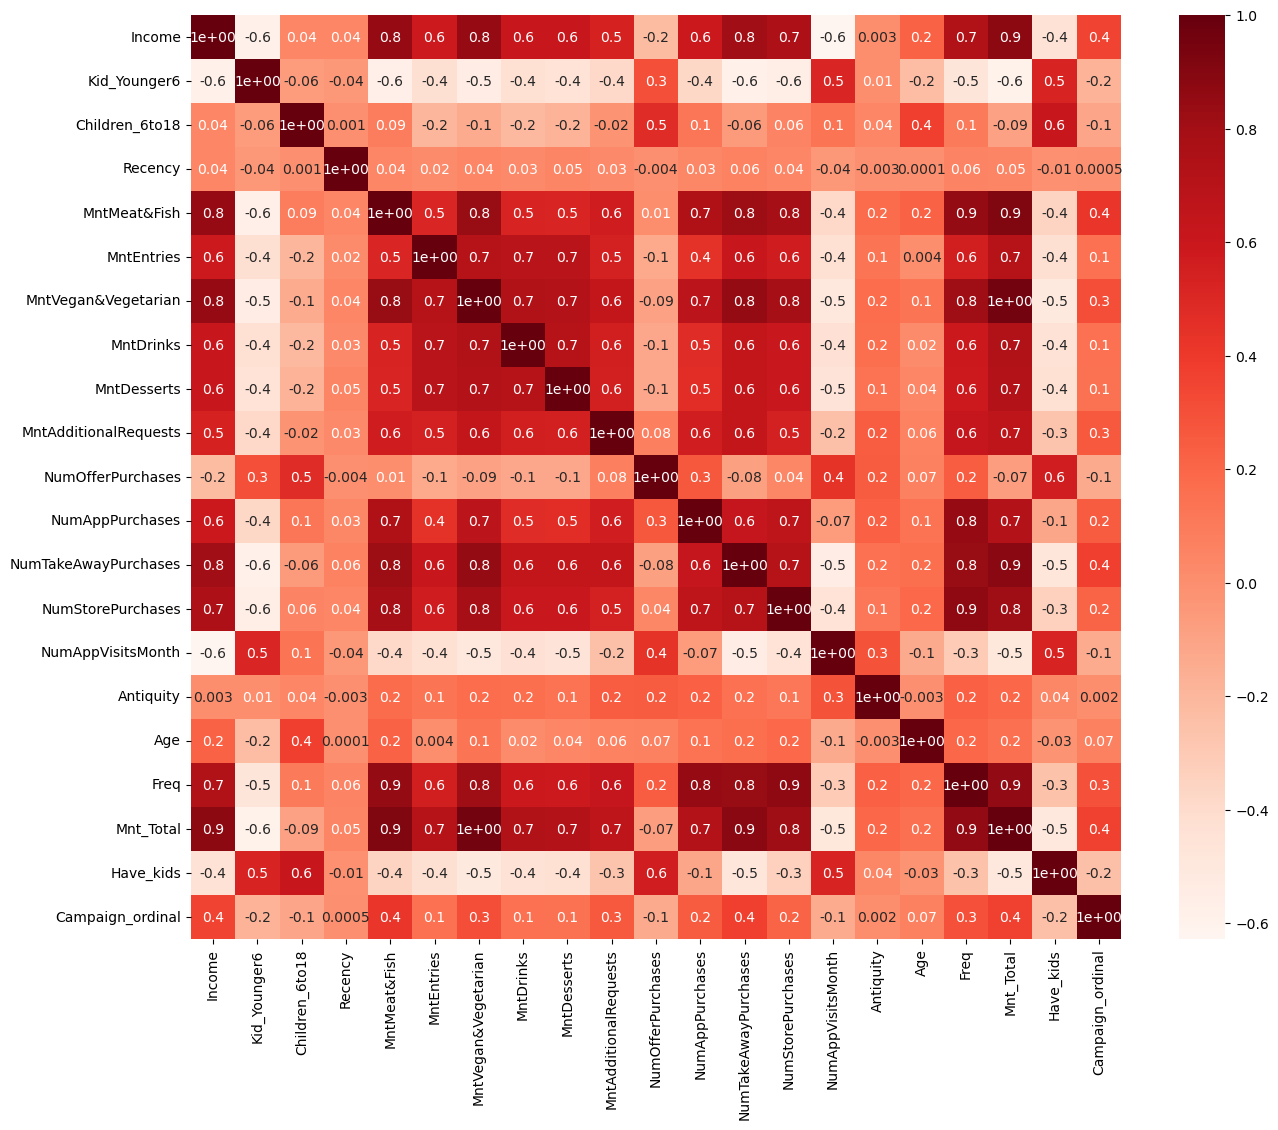

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


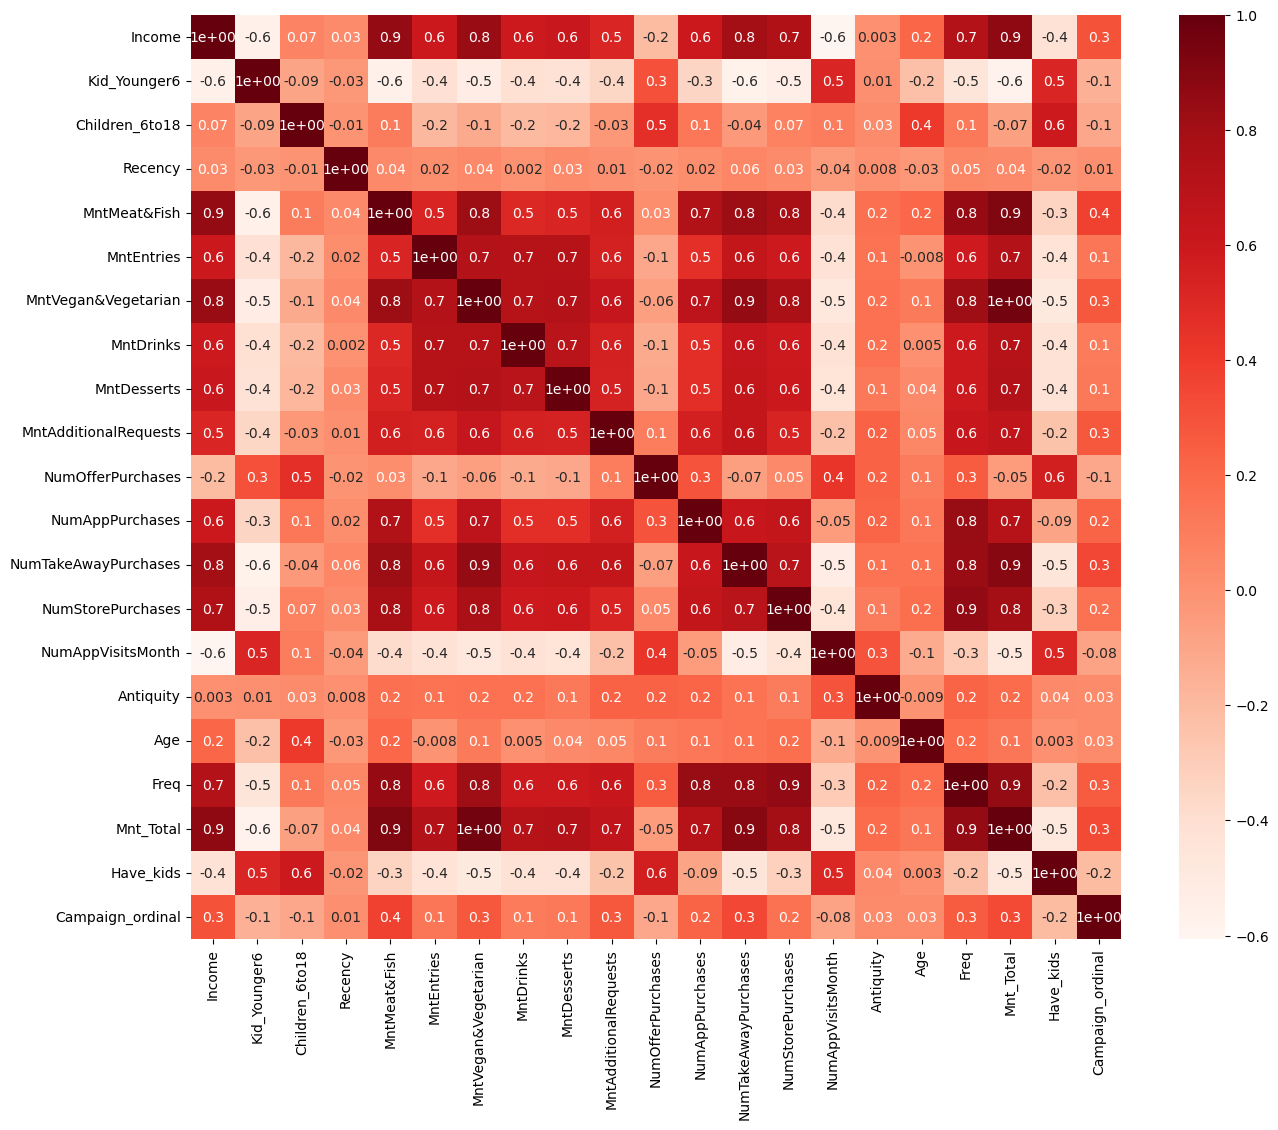

In [35]:
redundant_features(X, y)

Correlated features

- Income vs MntMeat&fish (.8)
- Income vs MntVegan&Vegetarian (0.8)
- Income vs NumTakeAwayPurchases (0.8)
- Income vs NumStorePurchases (0.8)
- Income vs Mnt_Total (0.9)

- MntMeat&Fish vs MntVegan&Vegetarian (.8)
- MntMeat&Fish vs NumTakeAwayPurchases (.8)
- MntMeat&Fish vs NumStorePurchases (.8)
- MntMeat&Fish vs Freq. (.8)
- MntMeat&Fish vs Mnt_Total (.9)

- MntVegan&Vegetarian vs NumTakeAwayPurchaes (.9)
- MntVegan&Vegetarian vs NumStorePurchases (.8)
- MntVegan&Vegetarian vs Freq. (.8)
- MntVegan&Vegetarian vs Mnt_Total (1)

- NumAppPurchases vs Freq. (.9)

- NumTakeAway vs Freq. (.8)
- NumTakeAway vs Mnt_Total (.9)

- NumStorePurchases vs Freq, (.9)
- NumStorePurchases vs Mnt_Total (.8)

- Freq. vs Mnt_Total (.9) 

### Decision Trees
We will now examine the feature importance of the independent variables in the training data using a decision tree.

In [36]:
def plot_importance(variables,name):
    imp_features = variables.sort_values()
    plt.figure(figsize=(4,5))
    imp_features.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()
    
    
def apply_dt(X_train, y_train):
    dt = DecisionTreeClassifier(random_state = 99).fit(X_train, y_train)
    feature_importances = pd.Series(dt.feature_importances_, index = X_train.columns)
    plot_importance(feature_importances, 'DT')

In [37]:
def select_best_features_dt(X, y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using decision Tree
        X_train = X_train.drop(['Education', 'Marital_Status', 'Kid_Younger6', 'Children_6to18',
       'Response_Cmp2', 'Response_Cmp3', 'Response_Cmp4', 'Response_Cmp5',
       'Response_Cmp1', 'Complain', 'Gender', 'Have_kids', 'Education_bins_3', 'Education_bins_2', 'Marital_Status_2', 'Marital_Status_4', 'Campaign_ordinal' ], axis = 1).copy()
        apply_dt(X_train, y_train)
        
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


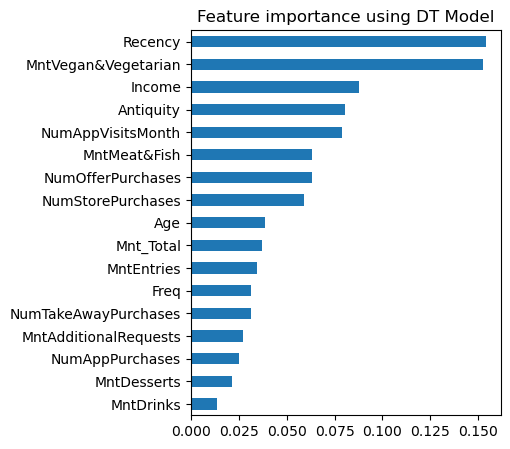

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


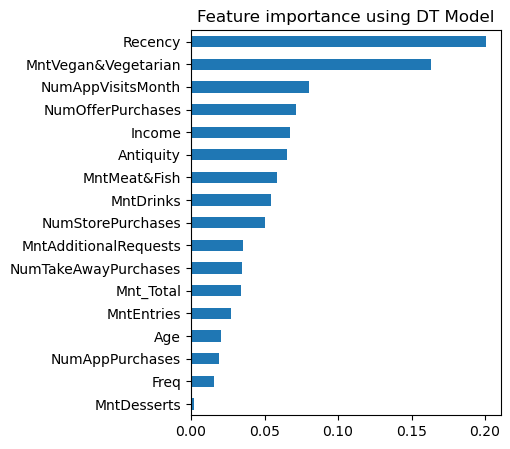

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


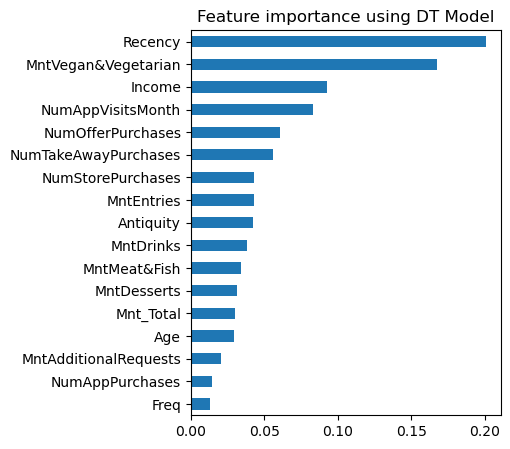

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


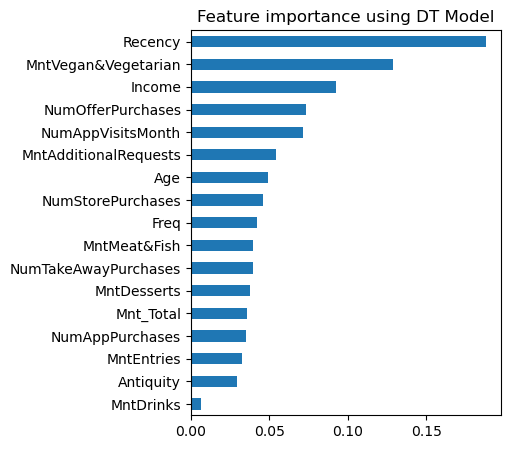

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


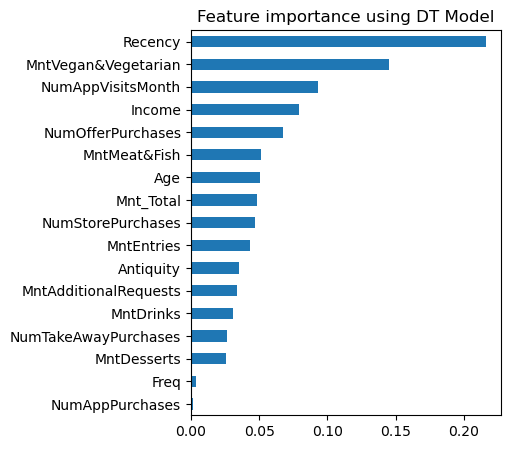

In [38]:
select_best_features_dt(X, y)

Top:
Split 1:

- MntVegan&Vegetarian 
- Income
- MntMeat&Fish
- NumStorePurchases
- NumTakeAwayPurchaes 
- Mnt_Total
- NumAppPurchases 

Split 2: 

- MntVegan&Vegetarian 
- MntMeat&Fish
- Income
- NumStorePurchases
- Mnt_Total
- NumTakeAwayPurchases 
- NumAppPurchases 

Split 3:

- MntVegan&Vegetarian
- Income
- NumTakeAwayPurchases 
- Mnt_total
- MntMeat&Fish
- NumStorePurchases

Split 4:

- MntVegan&Vegetarian
- Income
- MntMeat&Fish
- NumTakeAwayPurchases 
- Freq.
- NumStorePurchases

Split 5: 

- MntVegan&Vegetarian
- Income
- MntMeat&Fish
- Mnt_Total
- NumStorePurchases
- NumTakeAwayPurchases 

2 groups:

- Income, MntMeat&fish, MntVegan&Vegetarian, NumTakeAwayPurchases, NumStorePurchases, Mnt_Total, 

- Freq., MntMeat&fish, MntVegan&Vegetarian, NumAppPurchases, NumTakeAwayPurchases, NumStorePurchases, Mnt_Total

### Recursive Feature Elimination (RFE)

In [39]:
def apply_rfe(X_train, y_train):
    rfe = RFE(estimator = LogisticRegression(), n_features_to_select = 5)
    rfe.fit_transform(X = X_train, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns)
    print(selected_features)

### Lasso

In [40]:
def apply_lasso(X_train, y_train):
    lasso = LassoCV().fit(X_train, y_train)
    coef = pd.Series(lasso.coef_, index = X_train.columns)
    plot_importance(coef,'Lasso')

In [41]:
def select_best_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        # Check which features to use using RFE
        print('')
        print('----------------- RFE ----------------------')
        apply_rfe(X_train, y_train)
        
        # check which features to use using lasso
        print('')
        print('----------------- LASSO ----------------------')
        apply_lasso(X_train, y_train)
            
        # check which features to use using lasso
        print('')
        print('----------------- DT ----------------------')
        apply_dt(X_train, y_train)
            
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Income                   False
Recency                   True
MntMeat&Fish             False
MntEntries               False
MntVegan&Vegetarian       True
MntDrinks                False
MntDesserts              False
MntAdditionalRequests    False
NumOfferPurchases        False
NumAppPurchases          False
NumTakeAwayPurchases      True
NumStorePurchases        False
NumAppVisitsMonth         True
Antiquity                False
Age                      False
Freq                     False
Mnt_Total                 True
dtype: bool

----------------- LASSO ----------------------


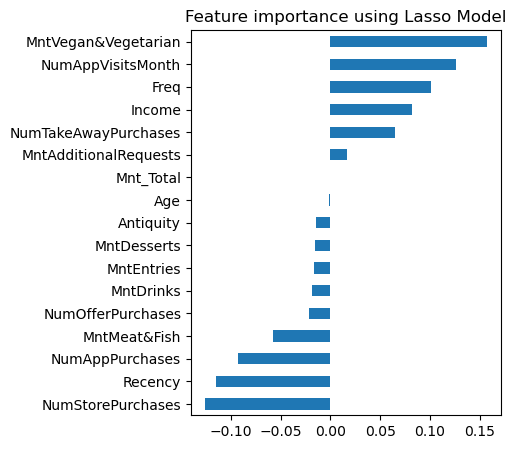


----------------- DT ----------------------


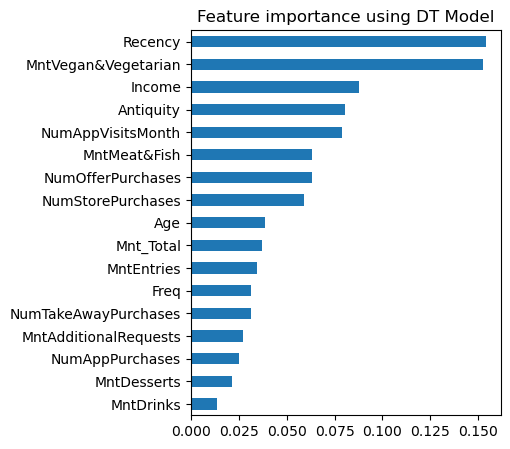

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Income                   False
Recency                   True
MntMeat&Fish             False
MntEntries               False
MntVegan&Vegetarian       True
MntDrinks                False
MntDesserts              False
MntAdditionalRequests    False
NumOfferPurchases        False
NumAppPurchases          False
NumTakeAwayPurchases      True
NumStorePurchases        False
NumAppVisitsMonth         True
Antiquity                False
Age                      False
Freq                     False
Mnt_Total                 True
dtype: bool

----------------- LASSO ----------------------


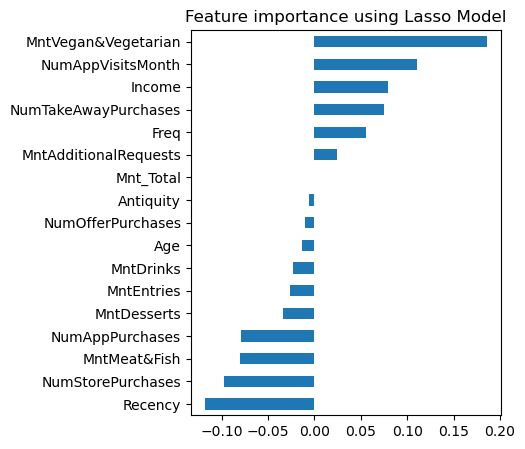


----------------- DT ----------------------


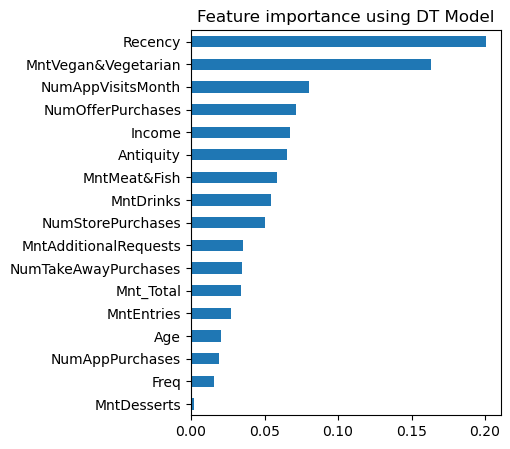

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Income                   False
Recency                   True
MntMeat&Fish             False
MntEntries               False
MntVegan&Vegetarian       True
MntDrinks                False
MntDesserts              False
MntAdditionalRequests    False
NumOfferPurchases        False
NumAppPurchases          False
NumTakeAwayPurchases      True
NumStorePurchases        False
NumAppVisitsMonth         True
Antiquity                False
Age                      False
Freq                     False
Mnt_Total                 True
dtype: bool

----------------- LASSO ----------------------


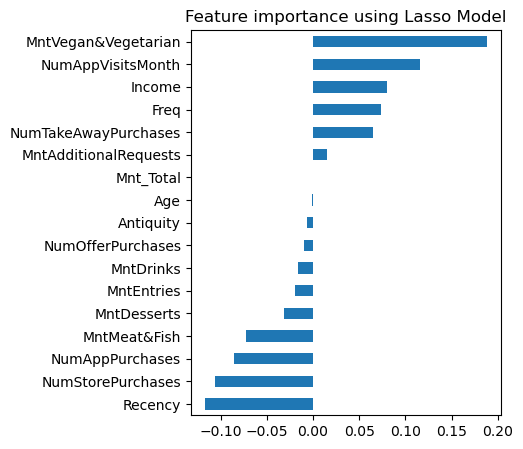


----------------- DT ----------------------


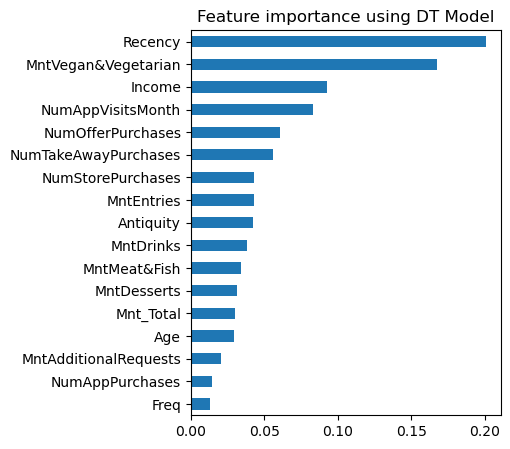

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Income                   False
Recency                   True
MntMeat&Fish             False
MntEntries               False
MntVegan&Vegetarian       True
MntDrinks                False
MntDesserts              False
MntAdditionalRequests    False
NumOfferPurchases        False
NumAppPurchases          False
NumTakeAwayPurchases      True
NumStorePurchases        False
NumAppVisitsMonth         True
Antiquity                False
Age                      False
Freq                     False
Mnt_Total                 True
dtype: bool

----------------- LASSO ----------------------


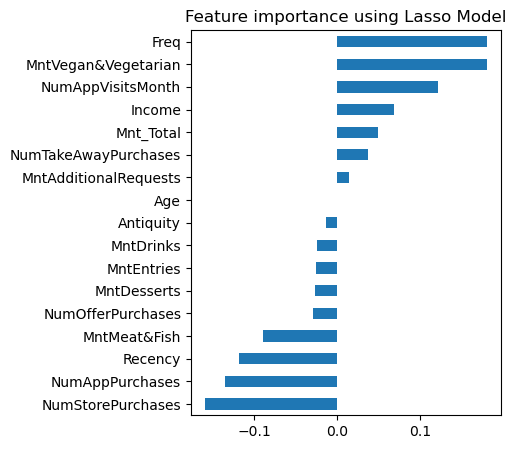


----------------- DT ----------------------


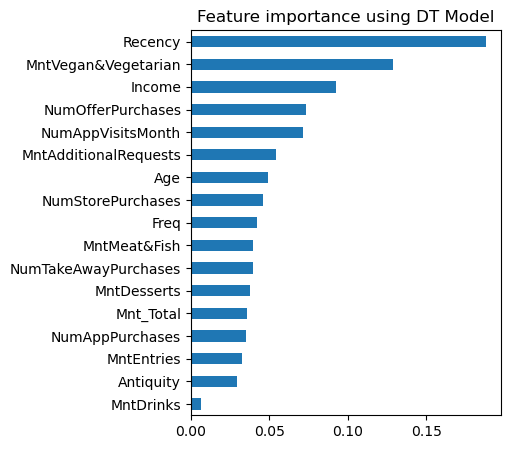

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
Income                   False
Recency                   True
MntMeat&Fish             False
MntEntries               False
MntVegan&Vegetarian       True
MntDrinks                False
MntDesserts              False
MntAdditionalRequests    False
NumOfferPurchases        False
NumAppPurchases          False
NumTakeAwayPurchases      True
NumStorePurchases         True
NumAppVisitsMonth        False
Antiquity                False
Age                      False
Freq                     False
Mnt_Total                 True
dtype: bool

----------------- LASSO ----------------------


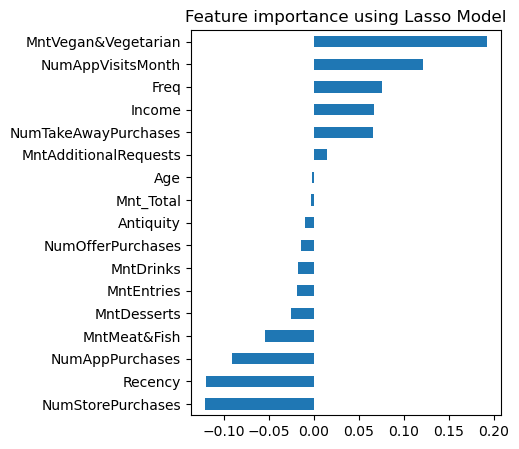


----------------- DT ----------------------


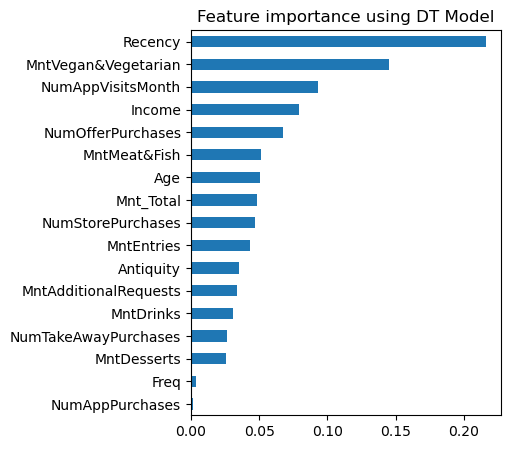

In [42]:
select_best_features(X[numeric.columns], y)

### Numerical Data

2 groups (highly correlated features):

Income, MntMeat&fish, MntVegan&Vegetarian, NumTakeAwayPurchases, NumStorePurchases, Mnt_Total,

Freq., MntMeat&fish, MntVegan&Vegetarian, NumAppPurchases, NumTakeAwayPurchases, NumStorePurchases, Mnt_Total

Correlated features

- Income vs MntMeat&fish (.8)
- Income vs MntVegan&Vegetarian (0.8)
- Income vs NumTakeAwayPurchases (0.8)
- Income vs NumStorePurchases (0.8)
- Income vs Mnt_Total (0.9)

- MntMeat&Fish vs MntVegan&Vegetarian (.8)
- MntMeat&Fish vs NumTakeAwayPurchases (.8)
- MntMeat&Fish vs NumStorePurchases (.8)
- MntMeat&Fish vs Freq. (.8)
- MntMeat&Fish vs Mnt_Total (.9)

- MntVegan&Vegetarian vs NumTakeAwayPurchaes (.9)
- MntVegan&Vegetarian vs NumStorePurchases (.8)
- MntVegan&Vegetarian vs Freq. (.8)
- MntVegan&Vegetarian vs Mnt_Total (1)

- NumAppPurchases vs Freq. (.9)

- NumTakeAway vs Freq. (.8)
- NumTakeAway vs Mnt_Total (.9)

- NumStorePurchases vs Freq, (.9)
- NumStorePurchases vs Mnt_Total (.8)

- Freq. vs Mnt_Total (.9) 

Which variables should we keep?

| Predictor | RFE | Lasso | DT | What to do? | 
| --- | --- | --- | --- | --- |
Recency | 5 YES | 5 YES | 5 YES |Keep |
Income | 0 YES | 5 YES  | 5 YES | ? |
MntMeat&Fish | 0 YES | 5 YES | 5 YES | ?  |
MntEntries | 5 YES | 0 YES | 0 YES | ? |
MntVegan&Vegetarian | 5 YES | 5 YES | 5 YES | Keep |
MntDrinks | 0 YES | 0 YES | 0 YES | Remove |
MntDesserts | 0 YES | 0 YES | 0 YES | Remove |
MntAdditionalRequests | 0 YES | 0 YES | 0 YES | Remove |
NumOfferPurchases | 0 YES | 0 YES | 5 YES | ? |
NumAppPurchases | 0 YES | 5 YES | 0 YES | ? |
NumTakeAwayPurchases | 5 YES | 4 YES | 1 YES | ? |
NumStorePurchases | 1 YES | 4 YES | 1 YES | ? |
NumAppVisitsMonth | 4 YES | 5 YES | 5 YES | Keep |
Antiquity | 0 YES | 0 YES  | 2 YES | Remove |
Age | 0 YES | 0 YES | 2 YES | Remove |
Freq. | 0 YES | 4 YES  | 0 YES | ? |
Mnt_Total | 5 YES | 0 YES | 1 YES | ? |


### Categorical Data


| Predictor | Chi-Square |Decision |
| --- | --- | --- | 
Education | 0 YES / 5 NO| REMOVE |
Education_bins_2| 0 YES /5 NO | REMOVE |
Education_bins_3 | 5 YES / 0 NO | KEEP |
Kid_Younger6 | 0 YES / 5 NO| REMOVE |
Children_6to18 | 5 YES / 0 NO | KEEP/SWITCH W RELATED VARS |
Have_kids | 5 YES / 0 NO | KEEP THIS OR Children_6to18 |
Response_Cmp1 | 5 YES / 0 NO |KEEP/SWITCH W RELATED/BINNED VARS
Response_Cmp2 | 5 YES / 0 NO |KEEP/SWITCH W RELATED/BINNED VARS
Response_Cmp3 | 5 YES / 0 NO |KEEP/SWITCH W RELATED/BINNED VARS
Response_Cmp4 | 5 YES / 0 NO |KEEP/SWITCH W RELATED/BINNED VARS
Response_Cmp5 | 5 YES / 0 NO |KEEP/SWITCH W RELATED/BINNED VARS
Campaign_ordinal |5 YES / 0 NO | KEEP/SWITCH W RELATED VARS
Complain  | 0 YES / 5 NO |REMOVE |
Gender | 0 YES / 5 NO |REMOVE |
Marital_Status | 5 YES / 0 NO |KEEP/SWITCH W RELATED/BINNED VARS
Marital_Status_2 | 5 YES / 0 NO |KEEP/SWITCH W RELATED/BINNED VARS
Marital_Status_4 |  5 YES / 0 NO | KEEP/SWITCH W RELATED/BINNED VARS




### Final Dataset

In [43]:

train_x = train[['Marital_Status_4', 'Income', 'Recency', 'MntVegan&Vegetarian',
                'NumOfferPurchases', 'NumAppPurchases', 'NumAppVisitsMonth', 'Campaign_ordinal',
                'DepVar']] 



test_x = test[['Marital_Status_4', 'Income', 'Recency', 'MntVegan&Vegetarian',
                  'NumOfferPurchases', 'NumAppPurchases', 'NumAppVisitsMonth','Campaign_ordinal']]

In [44]:
# Get dummies 
train_d = pd.get_dummies(train_x)
test_d = pd.get_dummies(test_x)

## Model Selection

We'll try different predictive algorithms and use the approppriates model assessment metrics to decide which model suits best according our busines problem.

In [45]:
def select_best_models(data, model):
    skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)
    X = data.drop('DepVar', axis = 1)
    y = data['DepVar'].copy()
    score_train, score_val = [],[]
        
    # perform the cross-validation    
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Apply model
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        score_train.append(f1_score(y_train, predictions_train))
        score_val.append(f1_score(y_val, predictions_val))

    avg_train = round(np.mean(score_train),3)
    avg_val = round(np.mean(score_val),3)
    std_train = round(np.std(score_train),2)
    std_val = round(np.std(score_val),2)

    return avg_train, std_train, avg_val, std_val

def show_results(models,data=train):
    df = pd.DataFrame(columns = ['Train','Validation', 'Diff'], index = list(models.keys()))
    count = 0
    for label,model in models.items():
        avg_train, std_train, avg_val, std_val = select_best_models(data, model)
        
        # store the results in the right row
        df.iloc[count] = str(avg_train) + '+/-' + str(std_train), str(avg_val) + '+/-' + str(std_val), abs(avg_train-avg_val)
        count+=1
    return df

### Models to Try

As a step within the Model Optimization we'll compare the performance of the different algorithms with the default parameters.

In [46]:
models = {
    'Logistic Regression': LogisticRegression(C= 10, penalty = 'l2', solver = 'lbfgs'),
    'KNN': KNeighborsClassifier(),
    'DT': DecisionTreeClassifier(max_depth=3, random_state=99),
    'NN': MLPClassifier(max_iter=2000, random_state=99),
    'SVC': SVC(kernel='rbf')
}

In [47]:
show_results(models, train_d)

,Train,Validation,Diff
Logistic Regression,0.666+/-0.01,0.656+/-0.03,0.01
KNN,0.722+/-0.02,0.588+/-0.09,0.134
DT,0.532+/-0.05,0.505+/-0.06,0.027
NN,0.826+/-0.02,0.708+/-0.04,0.118
SVC,0.765+/-0.01,0.713+/-0.05,0.052


### Model Optimization

Phase to optmize the performance of the models by fiddling with the algorithms hyperparameters and select the options that have the best model  performance. 

In [48]:
X = train_d.drop('DepVar', axis = 1)
y = train_d['DepVar'].copy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 99, stratify = y)

Logistic Regression

In [49]:
lr = LogisticRegression()

parameters_lr = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [100, 10, 1.0, 0.1, 0.01]
}

grid_search_lr = GridSearchCV(lr, parameters_lr, scoring = 'f1', return_train_score = True, cv = 5)
                              
grid_search_lr.fit(X,y)
print("Best Hyperparameters: ", grid_search_lr.best_params_)
print("Best Score: ", grid_search_lr.best_score_)

Best Hyperparameters:  {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score:  0.6554082833552777


In [50]:
final_model_lr = LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear')

SVM

In [51]:
svm = SVC()

parameters_svm = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [100, 10, 1.0, 0.1, 0.001]
}

grid_search_svm = GridSearchCV(svm, parameters_svm, scoring = 'f1', return_train_score = True, cv = 5)
grid_search_svm.fit(X,y)
print("Best Hyperparameters: ", grid_search_svm.best_params_)
print("Best Score: ", grid_search_svm.best_score_)

Best Hyperparameters:  {'C': 10, 'kernel': 'rbf'}
Best Score:  0.6988269421706159


In [52]:
final_model_svm = SVC(C= 10, kernel = 'rbf',probability=True)

Neural Networks

Getting layers number estimate

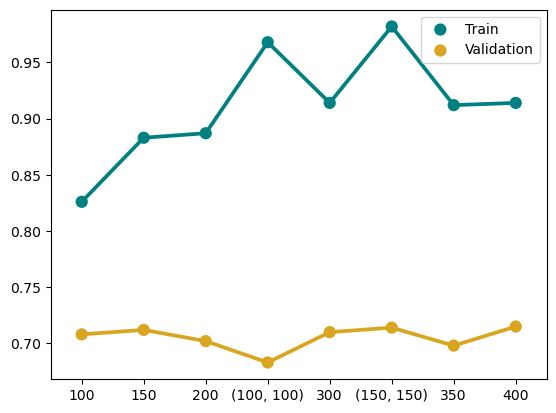

In [53]:
def get_models_nn(data, values):
    models = dict()
    results_train, results_val, names = [],[],[]
    
    # create the instances of each model with different values
    for value in values:
        models[str(value)] = MLPClassifier(hidden_layer_sizes = value, max_iter = 2000, random_state = 99)
        
    for name, model in models.items():
        avg_train, std_train, avg_val, std_val = select_best_models(data, model)
        results_train.append(avg_train)
        results_val.append(avg_val)
        names.append(name)

    return results_train, results_val, names

def point_plot(train, validation, values_try):
    sns.pointplot(x=values_try, y=train, color = 'teal', label = 'Train')
    sns.pointplot(x=values_try, y=validation, color = 'goldenrod', label = 'Validation')
    plt.legend()

values_try = [(100),(150),(200),(100,100),(300),(150,150),(350),(400)]
results_train, results_val, names = get_models_nn(train_d, values_try)
point_plot(results_train, results_val, names)

In [54]:
nn = MLPClassifier(max_iter=2000, random_state=99)

parameters_nn = {
    'hidden_layer_sizes': [(70),(80),(90),(100),(110),(120)],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling','adaptive'],
    'solver': ['sgd','adam'],
    'activation': ['logistic','relu']
}

rand_search_nn = RandomizedSearchCV(nn, parameters_nn, scoring = 'f1', return_train_score = True, cv = 5)
rand_search_nn.fit(X,y)
print("Best Hyperparameters: ", rand_search_nn.best_params_)
print("Best Score: ", rand_search_nn.best_score_)


Best Hyperparameters:  {'solver': 'adam', 'learning_rate_init': 0.0001, 'learning_rate': 'constant', 'hidden_layer_sizes': 100, 'activation': 'relu'}
Best Score:  0.7148227878754511


In [55]:
nn = MLPClassifier(max_iter=2000, random_state=99)

parameters_nn = {
    'hidden_layer_sizes': [(90)],
    'learning_rate_init': [0.01, 0.005, 0.015,0.05],
    'learning_rate': ['adaptive'],
    'solver': ['sgd'],
    'activation': ['relu']
}

grid_search_nn = GridSearchCV(nn, parameters_nn, scoring = 'f1', return_train_score = True, cv = 5)
grid_search_nn.fit(X,y)
print("Best Hyperparameters: ", grid_search_nn.best_params_)
print("Best Score: ", grid_search_nn.best_score_)

Best Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': 90, 'learning_rate': 'adaptive', 'learning_rate_init': 0.005, 'solver': 'sgd'}
Best Score:  0.7315994238523882


In [56]:
final_model_nn = MLPClassifier(activation = 'relu', 
                               hidden_layer_sizes = (90), 
                               learning_rate = 'adaptive', 
                               learning_rate_init = 0.005, 
                               solver = 'sgd', max_iter = 2000, random_state = 99)

### Comparing Final Models

In [57]:
final_models = {
    'Logistic Regression': LogisticRegression(C = 1, penalty = 'l1', solver = 'liblinear'),
    'NN': MLPClassifier(activation = 'relu', 
                               hidden_layer_sizes = (290), 
                               learning_rate = 'adaptive', 
                               learning_rate_init = 0.005, 
                               solver = 'sgd', max_iter = 2000, random_state = 99),
    'SVC': SVC(C= 10, kernel = 'rbf', probability=True)
}

show_results(final_models, train_d)

,Train,Validation,Diff
Logistic Regression,0.665+/-0.01,0.651+/-0.03,0.014
NN,0.78+/-0.01,0.736+/-0.03,0.044
SVC,0.843+/-0.01,0.704+/-0.04,0.139


### Roc Curve

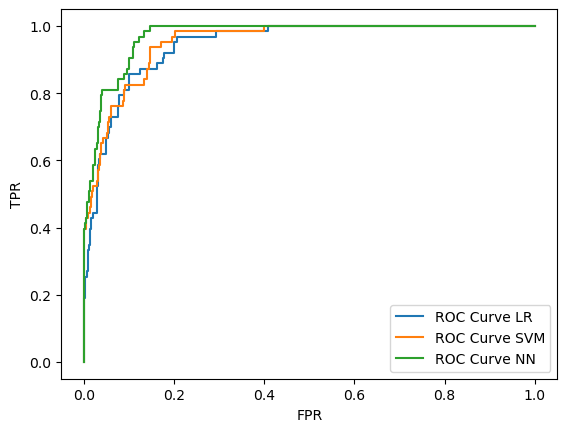

In [58]:
X = train_d.drop('DepVar', axis = 1)
y = train_d['DepVar'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  train_size = 0.8, 
                                                  random_state = 99, 
                                                  stratify = y)

model_lr = final_model_lr.fit(X_train, y_train)
model_svm = final_model_svm.fit(X_train, y_train)
model_nn = final_model_nn.fit(X_train, y_train)

prob_modelLR = final_model_lr.predict_proba(X_val)
prob_modelSVM =  final_model_svm.predict_proba(X_val)
prob_modelNN =  final_model_nn.predict_proba(X_val)

fpr_modelLR, tpr_modelKLR, thresholds_modelKLR = roc_curve(y_true = y_val, y_score = prob_modelLR[:,1])
fpr_modelSVM, tpr_modelSVM, thresholds_modelSVM = roc_curve(y_val, prob_modelSVM[:,1])
fpr_modelNN, tpr_modelNN, thresholds_modelNN = roc_curve(y_val, prob_modelNN[:,1])

plt.plot(fpr_modelLR, tpr_modelKLR,label="ROC Curve LR")
plt.plot(fpr_modelSVM, tpr_modelSVM, label="ROC Curve SVM")
plt.plot(fpr_modelNN, tpr_modelNN, label="ROC Curve NN")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

### Changing Probability Threshold

Best Threshold=0.413526, F-Score=0.779


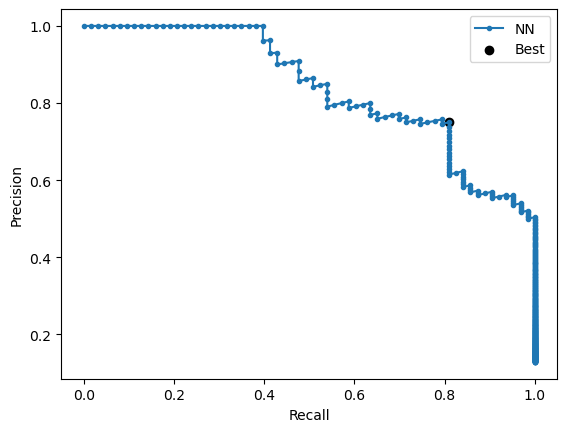

In [59]:
final_model = final_model_nn.fit(X_train, y_train)
predict_proba = final_model.predict_proba(X_val)

precision, recall, thresholds = precision_recall_curve(y_val, predict_proba[:,1])

# apply f1 score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.plot(recall, precision, marker='.', label='NN')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [60]:
X = train_d.drop('DepVar', axis = 1)
y = train_d['DepVar'].copy()

final_model = final_model_nn.fit(X, y)
final_model.predict(test_d)
predict_proba_test = final_model.predict_proba(test_d)
predict_proba_test
final_pred = []

for value in predict_proba_test[:,1]:
    if (value>=0.413526):
        final_pred.append(1)
    else:
        final_pred.append(0)
        
answer = pd.DataFrame()
answer['CustomerID'] = test_d.index
answer['DepVar'] = final_pred
answer.head(20)



,CustomerID,DepVar
0,3102,0
1,3105,0
2,3108,1
3,3111,0
4,3120,0
5,3123,0
6,3126,0
7,3132,0
8,3135,0
9,3138,0


In [61]:
answer.to_csv('answer.csv', index = False)